# Libraries

In [ ]:
!nvidia-smi

Thu Apr 25 18:14:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
''' Installing some required libraries. '''
!pip install python-levenshtein torchsummaryX wandb kaggle pytorch-nlp --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##  Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as tat

from torchsummaryX import summary
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import gc
import os
import math
import yaml
import random
import zipfile
import datetime

import glob
import wandb
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

''' Imports for decoding and distance calculation. '''
import Levenshtein

import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cuda


# Configurations

In [ ]:
%%writefile config.yaml

###### Dataset -----------------------------------------------------------------
train_dataset   : "train-clean-100"     # train-clean-50 (primarily for debugging purposes), train-clean-100
cepstral_norm   : True
input_dim       : 27
batch_size      : 64                    # decrease this as you modify the network architecture

###### Encoder Parameters ------------------------------------------
## Universal (Part I and II)
enc_dropout     : 0.23                   # [0.1, 0.4]
## Transformer-related (Part II)
enc_num_layers  : 1                     # [1, 3]
enc_num_heads   : 1                     # [1, 4]

###### Decoder Parameters ------------------------------------------
## Transformer-related (Part I and II)
dec_dropout     : 0.23                   # [0.1, 0.4]
dec_num_layers  : 2                     # [1, 3]
dec_num_heads   : 2                     # [1, 4]

###### Network Parameters ------------------------------------------------------
d_model         : 512                  # [256, 1024]
d_ff            : 2048                  # [512, 4096]

###### Learning Rate ---------------------------------------------------------------
learning_rate   : 1E-4                  # [1E-3, 1E-4], this will depend on the specified optimizer

###### Optimizer ---------------------------------------------------------------
optimizer       : "AdamW"               # Adam, AdamW

## if SGD
momentum        : 0.0
nesterov        : True

###### Scheduler ---------------------------------------------------------------
scheduler       : "CosineAnnealing"     # CosineAnnealing, ReduceLR

## if ReduceLR

## we are validating every 2 epochs but scheduler acts on every epoch. Set patience accordingly
## patience less than validation frquency can mean learning rate always dropping after patience epochs
## specify a suitable threshold too
factor          : 0.9
patience        : 3

###### Training Parameters -----------------------------------------------------
epochs          : 100

###### Name --------------------------------------------------------------------
Name: "Zhenjian Wang"                                # write your name here for study group

Writing config.yaml


In [ ]:
with open("config.yaml") as file:
    config = yaml.safe_load(file)

In [ ]:
config

{'train_dataset': 'train-clean-100',
 'cepstral_norm': True,
 'input_dim': 27,
 'batch_size': 64,
 'enc_dropout': 0.23,
 'enc_num_layers': 1,
 'enc_num_heads': 1,
 'dec_dropout': 0.23,
 'dec_num_layers': 2,
 'dec_num_heads': 2,
 'd_model': 512,
 'd_ff': 2048,
 'learning_rate': '1E-4',
 'optimizer': 'AdamW',
 'momentum': 0.0,
 'nesterov': True,
 'scheduler': 'CosineAnnealing',
 'factor': 0.9,
 'patience': 3,
 'epochs': 100,
 'Name': 'Zhenjian Wang'}

# Kaggle Dataset Download

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:

    # Enter your kaggle username <USERNAME> and key <KEY> here.
    f.write('{"username":"zhenjiantomwang1","key":"1de542fd1fd1d12ae0609f4a683151ae"}')

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73249 sha256=2a9c1afd4b908df582fd97dd47659c2cc771de4f78246ac9c70eb8e3dd24d4ea
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [ ]:
''' Downloading the dataset. '''
!kaggle competitions download -c automatic-speech-recognition-s24

''' Unzipping quickly and quietly. '''
!unzip -q automatic-speech-recognition-s24.zip -d ./data

100% 5.46G/5.46G [04:27<00:00, 24.2MB/s]
100% 5.46G/5.46G [04:27<00:00, 21.9MB/s]


In [ ]:
VOCAB = [
    "<pad>", "<sos>", "<eos>",
    "A",   "B",    "C",    "D",
    "E",   "F",    "G",    "H",
    "I",   "J",    "K",    "L",
    "M",   "N",    "O",    "P",
    "Q",   "R",    "S",    "T",
    "U",   "V",    "W",    "X",
    "Y",   "Z",    "'",    " ",
]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of Vocabulary    : {len(VOCAB)}")
print(f"VOCAB                   : {VOCAB}")
print(f"PAD_TOKEN               : {PAD_TOKEN}")
print(f"SOS_TOKEN               : {SOS_TOKEN}")
print(f"EOS_TOKEN               : {EOS_TOKEN}")

Length of Vocabulary    : 31
VOCAB                   : ['<pad>', '<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ']
PAD_TOKEN               : 0
SOS_TOKEN               : 1
EOS_TOKEN               : 2


## Dataset

In [ ]:
import torchaudio


In [ ]:
# Utils for network
torch.cuda.empty_cache()
class PermuteBlock(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

In [ ]:
''' This class is very similar to HW3P2 except for targets (now sequence of characters). '''

class SpeechDataset(torch.utils.data.Dataset):
    ''' memory inefficient : loading data in __init__ for simplicty

        You may decide to load data in __getitem__ if you wish.
        However, doing this memory inefficiently makes __init__ function takes
        the load of loading the data, and shifts it away from during the training process.
    '''

    def __init__(self, root_dir, partition, cepstral=True):

        self.mfcc_dir           = f"{root_dir}/{partition}*/mfcc/*"
        self.transcript_dir     = f"{root_dir}/{partition}*/transcripts/*"

        self.mfcc_files         = sorted(glob.glob(self.mfcc_dir))
        self.transcript_files   = sorted(glob.glob(self.transcript_dir))

        assert len(self.mfcc_files) == len(self.transcript_files)

        self.mfcc_files         = self.mfcc_files
        self.transcript_files   = self.transcript_files
        self.length             = len(self.transcript_files)
        self.vocab              = VOCAB

        print("Loaded Path: ", partition)

        self.mfccs, self.transcripts_shifted, self.transcripts_golden  = [], [], []
        for file in self.mfcc_files:
            mfcc = np.load(file)

            if cepstral:
                mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1E-8)
            self.mfccs.append(mfcc)

        for file in self.transcript_files:
            temp = np.load(file)[1:-1]


            self.transcripts_shifted.append(np.array([SOS_TOKEN] + [self.vocab.index(i) for i in temp]))
            self.transcripts_golden.append(np.array([self.vocab.index(i) for i in temp] + [EOS_TOKEN]))



        assert len(self.mfccs) == len(self.transcripts_shifted)


    def __len__(self): return self.length


    def __getitem__(self, ind):
        mfcc                = torch.FloatTensor(self.mfccs[ind])
        shifted_transcript  = torch.tensor(self.transcripts_shifted[ind])
        golden_transcript   = torch.tensor(self.transcripts_golden[ind])

        return mfcc, shifted_transcript, golden_transcript


    def collate_fn(self, batch):
        # @NOTE: batch corresponds to output from __getitem__ for a minibatch

        '''
        1.  Extract the features and labels from 'batch'.
        2.  We will additionally need to pad both features and labels,
            look at PyTorch's documentation for pad_sequence.
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lengths of features, and lengths of labels.

        '''

        # Batch of input mfcc coefficients.
        batch_mfcc              = [i[0] for i in batch]

        # Batch of output characters (shifted and golden).
        batch_transcript        = [i[1] for i in batch]
        batch_golden            = [i[2] for i in batch]

        lengths_mfcc            = [len(i) for i in batch_mfcc]
        lengths_transcript      = [len(i) for i in batch_transcript]

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first).
        batch_mfcc_pad          = pad_sequence(batch_mfcc, batch_first=True, padding_value=PAD_TOKEN)
        batch_transcript_pad    = pad_sequence(batch_transcript, batch_first=True, padding_value=PAD_TOKEN)
        batch_golden_pad        = pad_sequence(batch_golden, batch_first=True, padding_value=PAD_TOKEN)


        # You may apply some transformations, Time and Frequency masking, here in the collate function:
        # Food for Thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?

        audio_transforms = nn.Sequential(
            PermuteBlock(),
            torchaudio.transforms.TimeMasking(time_mask_param=10),
            torchaudio.transforms.FrequencyMasking(freq_mask_param=5),
            PermuteBlock()
        )

        batch_mfcc_pad = audio_transforms(batch_mfcc_pad)

        # Return the following values:
        # padded features, padded shifted labels, padded golden labels, actual length of features, actual length of the shifted labels
        return batch_mfcc_pad, batch_transcript_pad, batch_golden_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

In [ ]:
class SpeechTestDataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, partition, cepstral=True):

        self.mfcc_dir       = f"{root_dir}/{partition}*/mfcc/*"
        self.mfcc_files     = sorted(glob.glob(self.mfcc_dir))
        self.length         = len(self.mfcc_files)

        self.mfccs = []
        for file in self.mfcc_files:
            mfcc = np.load(file)
            if cepstral: mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1E-8)
            self.mfccs.append(mfcc)

        print("Loaded Path: ", partition)


    def __len__(self): return self.length


    def __getitem__(self, ind):
        mfcc = self.mfccs[ind]

        return torch.FloatTensor(mfcc)


    def collate_fn(self, batch):
        # @NOTE: batch corresponds to output from __getitem__ for a minibatch

        '''
        TODO:
        1.  Extract the features and labels from 'batch'.
        2.  We will additionally need to pad the features,
            look at PyTorch's documentation for pad_sequence.
        3.  Return batch of features, lengths of features.

        '''

        batch_mfcc      = batch
        batch_mfcc_pad  = pad_sequence(batch_mfcc, batch_first=True)
        lengths_mfcc    = [len(i) for i in batch_mfcc]

        return batch_mfcc_pad, torch.tensor(lengths_mfcc)

In [ ]:
# @NOTE: use the config file to specify PARTITION and CEPSTRAL
DATA_DIR        = '/content/data/11785-HW4P2'            # Enter your data directory here.
PARTITION       = 'train-clean-100'                # Enter your training directory here.
CEPSTRAL        = True               # Enter your cepstral_norm parameter here.

train_dataset   = SpeechDataset(
    root_dir    = DATA_DIR,
    partition   = PARTITION,
    cepstral    = CEPSTRAL
)

val_dataset     = SpeechDataset(
    root_dir    = DATA_DIR,
    partition   = "dev-clean",
    cepstral    = CEPSTRAL
)

test_dataset    = SpeechTestDataset(
    root_dir    = DATA_DIR,
    partition   = "test-clean",
    cepstral    = CEPSTRAL,
)

gc.collect()

Loaded Path:  train-clean-100
Loaded Path:  dev-clean
Loaded Path:  test-clean


638

## DataLoader

In [ ]:
train_loader    = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config["batch_size"],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True,
    collate_fn  = train_dataset.collate_fn
)

val_loader      = torch.utils.data.DataLoader(
    dataset     = val_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = val_dataset.collate_fn,
)

test_loader     = torch.utils.data.DataLoader(
    dataset     = test_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = test_dataset.collate_fn,
)

print("No. of Train MFCCs   : ", train_dataset.__len__())
print("Batch Size           : ", config["batch_size"])
print("Train Vatches        : ", train_loader.__len__())
print("Val Batches          : ", val_loader.__len__())
print("Test Batches         : ", test_loader.__len__())

No. of Train MFCCs   :  28539
Batch Size           :  64
Train Vatches        :  446
Val Batches          :  43
Test Batches         :  41


In [ ]:
''' Sanity Check '''

print("Checking the Shapes of the Data --\n")

for batch in train_loader:
    x_pad, y_shifted_pad, y_golden_pad, x_len, y_len, = batch

    print(f"x_pad shape:\t\t{x_pad.shape}")
    print(f"x_len shape:\t\t{x_len.shape}\n")

    print(f"y_shifted_pad shape:\t{y_shifted_pad.shape}")
    print(f"y_golden_pad shape:\t{y_golden_pad.shape}")
    print(f"y_len shape:\t\t{y_len.shape}\n")

    # print(y_shifted_pad)

    break

Checking the Shapes of the Data --

x_pad shape:		torch.Size([64, 1689, 27])
x_len shape:		torch.Size([64])

y_shifted_pad shape:	torch.Size([64, 254])
y_golden_pad shape:	torch.Size([64, 254])
y_len shape:		torch.Size([64])



## DataLoader Verification

- Train Dataset (train-clean-50)
```
Loaded Path:  train-clean-50
Max MFCC Length          :  1982
Avg MFCC Length          :  1256.06069100848
Max Transcript Length    :  354
Max Transcript Length    :  182.2676431424767
```

- Train Dataset (train-clean-100)
```
Loaded Path:  train-clean-100
Max MFCC Length          :  2448
Avg MFCC Length          :  1264.6258453344547
Max Transcript Length    :  399
Max Transcript Length    :  186.65321139493324
```

- Validation Dataset
```
Loaded Path:  dev-clean
Max MFCC Length          :  3260
Avg MFCC Length          :  713.3570107288198
Max Transcript Length    :  517
Max Transcript Length    :  107.71698113207547
```

- Test Dataset
```
Loaded Path:  test-clean
Max MFCC Length          :  27
Avg MFCC Length          :  27.0
```

- Population Stats
```
Max Length:  3260
```




# Introduction

Transformers are highly effective for speech recognition tasks because they utilize self-attention mechanisms, enabling them to analyze entire sequences of audio data in one shot. This allows for a nuanced understanding of long-range dependencies and the complex temporal dynamics inherent in speech. Compared to traditional models, transformers offer improved accuracy and efficiency, adeptly handling variations in speech patterns, accents, and intonations; thus, making them exceptionally suitable for advanced speech recognition applications.

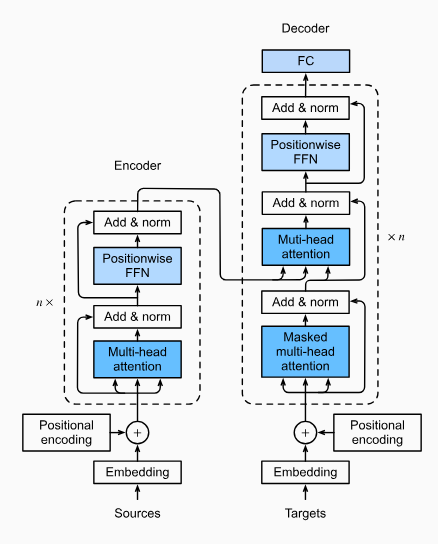

## Utilities


In [ ]:
def create_mask_1(padded_input, input_lengths=None, pad_idx=None):
    """ Create a mask to identify non-padding positions.

    Args:
        padded_input: The input tensor with padding, shape (N, T, ...) or (N, T).
        input_lengths: Optional, the actual lengths of each sequence before padding, shape (N,).
        pad_idx: Optional, the index used for padding tokens.

    Returns:
        A mask tensor with shape (N, T, 1), where non-padding positions are marked with 1 and padding positions are marked with 0.
    """

    assert input_lengths is not None or pad_idx is not None

    # Create a mask based on input_lengths
    if input_lengths is not None:
        N = padded_input.size(0)        # padded_input : (N x T x ...)
        non_pad_mask = padded_input.new_ones(padded_input.size()[:-1])  # (N x T)

        # Set the mask to 0 for padding positions
        for i in range(N):
          non_pad_mask[i, input_lengths[i]:] = 0

    if pad_idx is not None:             # padded_input : N x T

        assert padded_input.dim() == 2

        # Create a mask where non-padding positions are marked with 1 and padding positions are marked with 0
        non_pad_mask = padded_input.ne(pad_idx).float()

    return non_pad_mask.unsqueeze(-1)   # unsqueeze(-1) for broadcasting

In [ ]:
def create_mask_2(seq, pad_idx=None):
    """ Create a mask to prevent positions from attending to subsequent positions.

    Args:
        seq: The input sequence tensor, shape (batch_size, sequence_length).

    Returns:
        A mask tensor with shape (batch_size, sequence_length, sequence_length),
            where positions are allowed to attend to previous positions but not to subsequent positions.
    """

    sz_b, len_s = seq.size()

    # Create an upper triangular matrix with zeros on the diagonal and below (indicating allowed positions)
    #   and ones above the diagonal (indicating disallowed positions)
    subsequent_mask = torch.triu(
        torch.ones((len_s, len_s), device=seq.device, dtype=torch.uint8), diagonal=1)

    # Expand the mask to match the batch size, resulting in a mask for each sequence in the batch.
    mask = subsequent_mask.unsqueeze(0).expand(sz_b, -1, -1)  # b x ls x ls


    ''' Create a mask to ignore padding positions in the key sequence during attention calculation. '''

    # Expanding to fit the shape of key query attention matrix.
    if pad_idx != None:
      len_q = seq.size(1)

      # Create a mask where padding positions in the key sequence are marked with 1.
      padding_mask  = seq.eq(pad_idx)

      # Expand the mask to match the dimensions of the key-query attention matrix.
      padding_mask  = padding_mask.unsqueeze(1).expand(-1, len_q, -1)  # b x lq x lk
      mask          = (padding_mask + mask).gt(0)

    else:
      mask = mask.gt(0)

    return mask

In [ ]:
def create_mask_3(padded_input, input_lengths, expand_length):
    """ Create an attention mask to ignore padding positions in the input sequence during attention calculation.

    Args:
        padded_input: The input tensor with padding, shape (N, Ti, ...).
        input_lengths: The actual lengths of each sequence before padding, shape (N,).
        expand_length: The length to which the attention mask should be expanded,
            usually equal to the length of the sequence that the attention scores will be applied to.

    Returns:
        An attention mask tensor with shape (N, expand_length, Ti),
            where padding positions in the input sequence are marked with 1 and other positions are marked with 0.
    """

    # Create a mask to identify non-padding positions, shape (N, Ti, 1)
    # (N x Ti x 1)
    non_pad_mask    = create_mask_1(padded_input, input_lengths=input_lengths)

    # Invert the mask to identify padding positions, shape (N, Ti)
    # N x Ti, lt(1) like-not operation
    pad_mask        = non_pad_mask.squeeze(-1).lt(1)


    # Expand the mask to match the dimensions of the attention matrix, shape (N, expand_length, Ti)
    attn_mask       = pad_mask.unsqueeze(1).expand(-1, expand_length, -1)

    return attn_mask

In [ ]:
class ScaledDotProductAttention(torch.nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature    = temperature                       # Scaling factor for the dot product
        self.dropout        = torch.nn.Dropout(attn_dropout)    # Dropout layer for attention weights
        self.softmax        = torch.nn.Softmax(dim=2)           # Softmax layer along the attention dimension

    def forward(self, q, k, v, mask=None):

        # Calculate the dot product between queries and keys.
        attn = torch.bmm(q, k.transpose(1, 2))

        # Scale the dot product by the temperature.
        attn = attn / self.temperature

        if mask is not None:
            # Apply the mask by setting masked positions to a large negative value.
            # This ensures they have a softmax score close to zero.
            mask_value = -1e+30 if attn.dtype == torch.float32 else -1e+4
            attn = attn.masked_fill(mask, mask_value)

        # Apply softmax to obtain attention weights.
        attn    = self.softmax(attn)

        # Apply dropout to the attention weights.
        attn    = self.dropout(attn)

        # Compute the weighted sum of values based on the attention weights.
        output  = torch.bmm(attn, v)

        return output, attn # Return the attention output and the attention weights.

In [ ]:
def save_attention_plot(attention_weights, epoch=0):
    ''' function for saving attention weights plot to a file

        @NOTE: default starter code set to save cross attention
    '''

    plt.clf()  # Clear the current figure
    sns.heatmap(attention_weights, cmap="GnBu")  # Create heatmap

    # Save the plot to a file. Specify the directory if needed.
    plt.savefig(f"cross_attention-epoch{epoch}.png")

In [ ]:
class MultiHeadAttention(torch.nn.Module):
    ''' Multi-Head Attention Module '''

    def __init__(self, n_head, d_model, dropout=0.1):
        super().__init__()

        self.n_head = n_head # Number of attention heads
        self.d_k    = d_model // n_head
        self.d_v    = d_model // n_head


        # Linear layers for projecting the input query, key, and value to multiple heads
        self.w_qs   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_ks   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_vs   = torch.nn.Linear(d_model, n_head * self.d_v)

        torch.nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_v)))

        # Initialize the weights of the linear layers
        self.attention = ScaledDotProductAttention(
            temperature=np.power(self.d_k, 0.5), attn_dropout=dropout)

        # Final linear layer to project the concatenated outputs of the attention heads back to the model dimension
        self.fc = torch.nn.Linear(n_head * self.d_v, d_model)

        torch.nn.init.xavier_normal_(self.fc.weight)

        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):

        # following key, value, query standard computation
        d_k, d_v, n_head    = self.d_k, self.d_v, self.n_head
        sz_b, len_q, _      = q.size()
        sz_b, len_k, _      = k.size()
        sz_b, len_v, _      = v.size()

        # Project the input query, key, and value to multiple heads
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Rearrange the dimensions to group the heads together for parallel processing
        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k) # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k) # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v) # (n*b) x lv x dv

        # Repeat the mask for each attention head if a mask is provided
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1)

        # Apply scaled dot-product attention to the projected query, key, and value
        output, attn    = self.attention(q, k, v, mask=mask)

        # Rearrange the output back to the original order and concatenate the heads
        output          = output.view(n_head, sz_b, len_q, d_v)
        output          = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dv)

        output          = self.dropout(self.fc(output))

        return output, attn

## Transformer Modules

### Positional Encoding

In [ ]:
class PositionalEncoding(torch.nn.Module):
    ''' Position Encoding from Attention Is All You Need Paper '''

    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # Initialize a tensor to hold the positional encodings
        pe          = torch.zeros(max_len, d_model)

        # Create a tensor representing the positions (0 to max_len-1)
        position    = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculate the division term for the sine and cosine functions
        # This term creates a series of values that decrease geometrically, used to generate varying frequencies for positional encodings
        div_term    = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute the positional encodings using sine and cosine functions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Reshape the positional encodings tensor and make it a buffer
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):

      return x + self.pe[:, :x.size(1)]

### Feed Forward Networks

In [ ]:
class FeedForward(torch.nn.Module):
    ''' Projection Layer (Fully Connected Layers) '''

    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()

        self.linear_1   = torch.nn.Linear(d_model, d_ff)
        self.dropout    = torch.nn.Dropout(dropout)
        self.linear_2   = torch.nn.Linear(d_ff, d_model)

    def forward(self, x):

        # Apply the first linear layer, GeLU activation, and then dropout
        x = self.dropout(torch.nn.functional.gelu(self.linear_1(x)))

         # Apply the second linear layer to project the dimension back to d_model
        x = self.linear_2(x)

        return x

# PART #1

In this part we will use a simple CNN-LSTM as an encoder with a Transformer Decoder (with Self-Attention and Cross-Attention).

## CNN-LSTM Encoder

In [ ]:
class Permute(nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

In [ ]:
class pBLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()
        self.blstm = torch.nn.LSTM(input_size=2*input_size, hidden_size=hidden_size, bidirectional=True, batch_first=True)

    def forward(self, x_packed):
        x_padded, x_lens = pad_packed_sequence(x_packed, batch_first=True)
        x_padded, x_lens = self.trunc_reshape(x_padded, x_lens)
        x_packed = pack_padded_sequence(x_padded, x_lens, batch_first=True, enforce_sorted=False)
        output_packed, hidden = self.blstm(x_packed)
        return output_packed

    def trunc_reshape(self, x, x_lens):
        if x.shape[1]%2==1:
            x = x[:,:-1,:]
        x = x.reshape((x.shape[0], int(x.shape[1]//2), x.shape[2]*2))
        x_lens = (x_lens/2).type(torch.int)
        return x, x_lens

In [ ]:
from torch.autograd import Variable

class LockedDropout(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = dropout

    def forward(self, x):
        if not self.training or not self.dropout:
            return x
        x_unpacked, x_lens = pad_packed_sequence(x, batch_first=True)
        m = x.data.new(x_unpacked.size(0), 1, x_unpacked.size(2)).bernoulli_(1 - self.dropout)
        mask = Variable(m, requires_grad=False) / (1 - self.dropout)
        mask = mask.expand_as(x_unpacked)
        out = mask * x_unpacked
        return pack_padded_sequence(out, lengths=x_lens, batch_first=True, enforce_sorted=False)

In [ ]:
class CNN_LSTM_Encoder(torch.nn.Module):
    ''' The Encoder takes utterances as inputs and returns latent feature representations '''

    def __init__(self, input_size, encoder_hidden_size, enc_dropout=0.2):
        super(CNN_LSTM_Encoder, self).__init__()

        self.embedding = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, 2*input_size, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm1d(2*input_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv1d(2*input_size, 4*input_size, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm1d(4*input_size),
            torch.nn.ReLU(inplace=True)
        )

        self.bilstm = torch.nn.LSTM(input_size=4*input_size, hidden_size=encoder_hidden_size, bidirectional=True, batch_first=True, dropout=enc_dropout)

        self.pBLSTMs = torch.nn.Sequential(
            pBLSTM(2 * encoder_hidden_size, encoder_hidden_size),
            LockedDropout(dropout=2*enc_dropout),
            pBLSTM(2*encoder_hidden_size, 2*encoder_hidden_size),
            LockedDropout(dropout=enc_dropout),
        )

        self.permute = PermuteBlock()

    def forward(self, x, x_lens):
        x = self.permute(x)
        x = self.embedding(x)
        x = self.permute(x)

        x_packed        = pack_padded_sequence(x, x_lens, batch_first= True, enforce_sorted=False)
        x_packed, _     = self.bilstm(x_packed)
        x_packed        = self.pBLSTMs(x_packed)
        encoder_outputs, encoder_lens = pad_packed_sequence(x_packed, batch_first=True)

        return encoder_outputs, encoder_lens

## Transformer Decoder

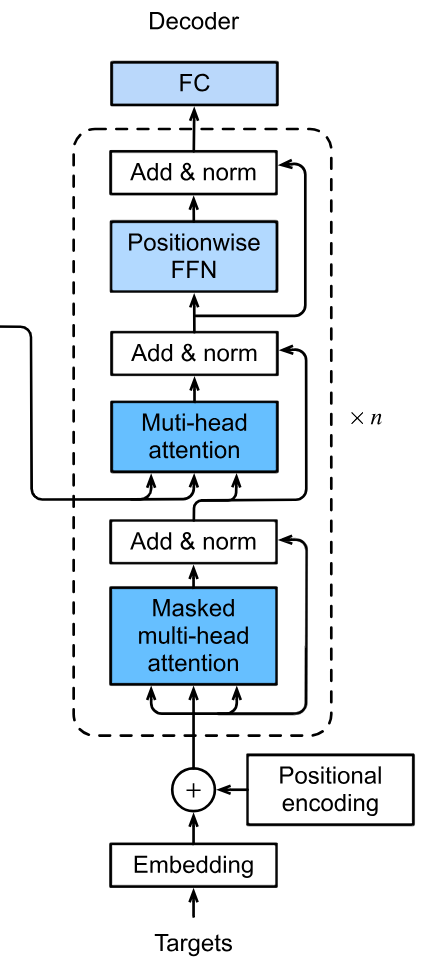

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # @TODO: fill in the blanks appropriately (given the modules above)
        self.mha1       = MultiHeadAttention(num_heads, d_model, dropout)
        self.mha2       = MultiHeadAttention(num_heads, d_model, dropout)
        self.ffn        = FeedForward(d_model, d_ff, dropout)

        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.layernorm3 = nn.LayerNorm(d_model)

        self.dropout1   = nn.Dropout(dropout)
        self.dropout2   = nn.Dropout(dropout)
        self.dropout3   = nn.Dropout(dropout)


    def forward(self, padded_targets, enc_output, enc_input_lengths, dec_enc_attn_mask, pad_mask, slf_attn_mask):

        # Masked Multi-Head Attention
        #   (1) apply MHA with the lookahead mask
        ''' TODO '''
        attn_output1, slf_attn_weights = self.mha1(padded_targets, padded_targets, padded_targets, slf_attn_mask)

        # Skip (Residual) Connections
        #   (1) perform dropout on padded attention output
        #   (2) add the true outputs (padded_targets) as a skip connection
        ''' TODO '''
        attn_output1 = self.dropout1(attn_output1)


        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        attn_output1 = self.layernorm1(attn_output1 + padded_targets)

        # Masked Multi-Head Attention on Encoder Outputs and Targets
        #   (1) apply MHA with the self-attention mask
        ''' TODO '''
        attn_output2, enc_dec_attn_weights = self.mha2(attn_output1, enc_output, enc_output, dec_enc_attn_mask)


        # Skip (Residual) Connections
        #   (1) perform dropout on this second padded attention output
        #   (2) add the output of first MHA block as a skip connection
        ''' TODO '''
        attn_output2 = self.dropout2(attn_output2)


        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        attn_output2 = self.layernorm2(attn_output2 + attn_output1)

        # Feed Forward Network
        #   (1) pass through the FFN
        ''' TODO '''
        ffn_output = self.ffn(attn_output2)

        # Skip (Residual) Connections
        #   (1) perform dropout on the output
        #   (2) add the output of second MHA block as a skip connection
        ''' TODO '''
        ffn_output = self.dropout3(ffn_output)


        # apply Layer Normalization on this resulting value
        ''' TODO '''
        ffn_output = self.layernorm3(ffn_output + attn_output2)

        # return the network output and both attention weights (for mha1 and mha2)
        # @NOTE: returning the self attention weights first
        return ffn_output, slf_attn_weights, enc_dec_attn_weights

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout,
            target_vocab_size, max_seq_length, eos_token, sos_token, pad_token):
        super().__init__()

        self.EOS_TOKEN      = eos_token
        self.SOS_TOKEN      = sos_token
        self.PAD_TOKEN      = pad_token

        self.max_seq_length = max_seq_length
        self.num_layers     = num_layers

        # use torch.nn.ModuleList() with list comprehension looping through num_layers
        # @NOTE: think about what stays constant per each DecoderLayer (how to call DecoderLayer)
        # @HINT: We've implemented this for you.
        self.dec_layers = torch.nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )

        self.target_embedding       = nn.Embedding(num_embeddings=target_vocab_size, embedding_dim=d_model, padding_idx=pad_token)
        self.positional_encoding    = PositionalEncoding(d_model)
        self.final_linear           = nn.Linear(d_model, target_vocab_size)
        self.dropout                = nn.Dropout(dropout)


    def forward(self, padded_targets, enc_output, enc_input_lengths):

        # create a padding mask for the padded_targets with <PAD_TOKEN>
        ''' TODO '''
        pad_mask = create_mask_1(padded_targets, pad_idx=self.PAD_TOKEN)


        # creating an attention mask for the future subsequences (look-ahead mask)
        ''' TODO '''

        attn_msk2 = create_mask_2(padded_targets)

        # creating attention mask to ignore padding positions in the input sequence during attention calculation
        ''' TODO '''

        attn_msk_3 = create_mask_3(enc_output,  enc_input_lengths,  padded_targets.shape[1])

        # computing embeddings for the target sequence
        ''' TODO '''

        target_emb = self.target_embedding(padded_targets)

        # computing Positional Encodings with the embedded targets and apply dropout
        ''' TODO '''

        positional_enc = self.dropout(self.positional_encoding(target_emb))

        # passing through decoder layers
        # @NOTE: store your mha1 and mha2 attention weights inside a dictionary
        # @NOTE: you will want to retrieve these later so store them with a useful name
        ''' TODO '''

        # linear layer (Final Projection) for next character prediction
        ''' TODO '''

        weights_dictionary = {}
        o = positional_enc
        for i in range(self.num_layers):
            o, att_weight, enc_dec_weight = self.dec_layers[i](o, enc_output, enc_input_lengths, \
                                                             attn_msk_3, pad_mask, attn_msk2)
            weights_dictionary[f"layer#{i+1}_mha1"] = att_weight
            weights_dictionary[f"layer#{i+1}_mha2"] = enc_dec_weight

        # return the network output and the dictionary of attention weights
        o = self.final_linear(o)
        return o, weights_dictionary


    def recognize_greedy_search(self, enc_outputs, enc_input_lengths):
        ''' passes the encoder outputs and its corresponding lengths through autoregressive network

            @NOTE: You do not need to make changes to this method.
        '''

        batch_size = enc_outputs.size(0)

        # start with the <SOS> token for each sequence in the batch
        target_seq = torch.full((batch_size, 1), self.SOS_TOKEN, dtype=torch.long).to(enc_outputs.device)

        finished = torch.zeros(batch_size, dtype=torch.bool).to(enc_outputs.device)

        for _ in range(self.max_seq_length):

            # preparing attention masks
            # filled with ones becaues we want to attend to all the elements in the sequence
            pad_mask = torch.ones_like(target_seq).float().unsqueeze(-1)  # (batch_size x i x 1)
            slf_attn_mask_subseq = create_mask_2(target_seq)

            x = self.positional_encoding(self.target_embedding(target_seq))

            for i in range(self.num_layers):
                x, block1, block2 = self.dec_layers[i](
                    x, enc_outputs, enc_input_lengths, None, pad_mask, slf_attn_mask_subseq)

            seq_out = self.final_linear(x[:, -1])
            logits = torch.nn.functional.log_softmax(seq_out, dim=1)

            # selecting the token with the highest probability
            # @NOTE: this is the autoregressive nature of the network!
            next_token = logits.argmax(dim=-1).unsqueeze(1)

            # appending the token to the sequence
            target_seq = torch.cat([target_seq, next_token], dim=-1)

            # checking if <EOS> token is generated
            eos_mask = next_token.squeeze(-1) == self.EOS_TOKEN
            # or opration, if both or one of them is true store the value of the finished sequence in finished variable
            finished |= eos_mask

            # end if all sequences have generated the EOS token
            if finished.all(): break

        # remove the initial <SOS> token and pad sequences to the same length
        target_seq = target_seq[:, 1:]
        max_length = target_seq.size(1)
        target_seq = torch.nn.functional.pad(target_seq,
            (0, self.max_seq_length - max_length), value=self.PAD_TOKEN)

        return target_seq

## CNN-LSTM Encoder + Speech Transformer Decoder

In this section, let's build the first (simplest) Transformer network by combining the CNN-LSTM encoder and our Transformer Decoder.

In [ ]:
class SpeechTransformer(torch.nn.Module):

    def __init__(self, input_dim, dec_num_layers, dec_num_heads,
                    d_model, d_ff, target_vocab_size, eos_token, sos_token,
                    pad_token, enc_dropout, dec_dropout, max_seq_length=512):

        super(SpeechTransformer, self).__init__()

        self.encoder    = CNN_LSTM_Encoder(input_dim, 256, enc_dropout)

        self.proj       = torch.nn.Linear(1024, d_model)

        # @NOTE: layernorm here is meant to normalize the dynamic ranges of
        #   the cross attention weights such that the model doesn't bias
        #   itself to only using the cross attention weights and neglect using
        #   the multi-head self attention weights.
        #   This is to enfoce the Language Model constraints in the Decoder.
        #   This is an experimental change -- you may try it if you want.
        # self.layernorm  = torch.nn.LayerNorm(d_model)

        self.decoder    = Decoder(dec_num_layers, d_model, dec_num_heads, d_ff,
                dec_dropout, target_vocab_size, max_seq_length, eos_token, sos_token, pad_token)

        # You can experiment with different weight initialization schemes or no initialization here
        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

    def forward(self, padded_input, input_lengths, padded_target, target_lengths):

        # passing through Encoder
        encoder_output, encoder_lens = self.encoder(padded_input, input_lengths)

        # adding projection layer to change dimension of encoder_outputs to match d_model
        encoder_output = self.proj(encoder_output)

        # @NOTE: adding layernorm to adjust dynamic ranges of the encoder_outputs
        # @NOTE: uncomment this if you choose to use layernorm described in __init__ above
        # encoder_output = self.layernorm(encoder_output)

        # passing Encoder output and Attention masks through Decoder
        output, attention_weights = self.decoder(padded_target, encoder_output, encoder_lens)

        return output, attention_weights

    def recognize(self, inp, inp_len):
        """ sequence-to-sequence greedy search -- decoding one utterence at a time """

        encoder_outputs, encoder_lens  = self.encoder(inp, inp_len)
        encoder_outputs                = self.proj(encoder_outputs)
        out                            = self.decoder.recognize_greedy_search(encoder_outputs, encoder_lens)

        return out

## Model Setup


In [ ]:
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
config

{'train_dataset': 'train-clean-100',
 'cepstral_norm': True,
 'input_dim': 27,
 'batch_size': 64,
 'enc_dropout': 0.23,
 'enc_num_layers': 1,
 'enc_num_heads': 1,
 'dec_dropout': 0.23,
 'dec_num_layers': 2,
 'dec_num_heads': 2,
 'd_model': 512,
 'd_ff': 2048,
 'learning_rate': '1E-4',
 'optimizer': 'AdamW',
 'momentum': 0.0,
 'nesterov': True,
 'scheduler': 'CosineAnnealing',
 'factor': 0.9,
 'patience': 3,
 'epochs': 100,
 'Name': 'Zhenjian Wang'}

In [ ]:
''' Please refer to the config file and top sections to fill in the following '''

model = SpeechTransformer(
input_dim                   = config["input_dim"],
dec_num_layers              = config["dec_num_layers"],
dec_num_heads               = config["dec_num_heads"],

d_model                     = config["d_model"],
d_ff                        = config["d_ff"],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

enc_dropout                 = config["enc_dropout"],
dec_dropout                 = config["dec_dropout"],

# decrease to a small number if you are just trying to implement the network
max_seq_length              = 550 , # Max sequence length for transcripts. Check data verification.
).to(device)

def num_parameters(mode):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params / 1E6

para = num_parameters(model)
print("#"*10)
print(f"Model Parameters:\n {para}")
print("#"*10)

##########
Model Parameters:
 18.676327
##########


### Loading the CNN-LSTM Checkpoint

---
For ease of training we use a pretrained LSTM -- load the .pth file.

Download the weights from here - https://drive.google.com/file/d/1wRcHwCvxksxiPv6WQykOkY9i4bip-ooa/view?usp=sharing

In [ ]:
model.encoder.load_state_dict(torch.load("/content/gdrive/MyDrive/pblstm_fast_training_weights.pth"))

<All keys matched successfully>

## Loss, Optimizer, and Scheduler Definitions

In [ ]:
loss_func   = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

In [ ]:
''' defining optimizer '''

if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(model.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(model.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(model.parameters(),
                                lr=float(config["learning_rate"]),
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = config["epochs"], eta_min=1E-8)

In [ ]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {"model_state_dict"         : model.state_dict(),
         "optimizer_state_dict"     : optimizer.state_dict(),
         "scheduler_state_dict"     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1],
         "epoch"                    : epoch},
         path
    )

def load_model(path, model, metric= "valid_acc", optimizer= None, scheduler= None):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    epoch   = checkpoint["epoch"]
    metric  = checkpoint[metric]

    return [model, optimizer, scheduler, epoch, metric]

## Training and Validation Modules

### Levenshtein Distance

In [ ]:
''' utility function which takes a sequence of indices and converts them to a list of characters '''
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices:   # looping through all indices

        if int(i) == SOS_TOKEN:     # If SOS is encountered, don't add it to the final list
            continue
        elif int(i) == EOS_TOKEN:   # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])

    return tokens

In [ ]:
''' utility function for Levenshtein Distantce quantification '''
def calc_edit_distance(predictions, y, y_len, vocab=VOCAB, print_example=False):

    dist = 0.0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size):

        y_sliced    = indices_to_chars(y[batch_idx, 0 : y_len[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # strings - when you are using characters from the SpeechDataset
        y_string    = "".join(y_sliced)
        pred_string = "".join(pred_sliced)

        dist        += Levenshtein.distance(pred_string, y_string)

    if print_example:
        print("\nGround Truth : ", y_string)
        print("Prediction   : ", pred_string)

    dist /= batch_size

    return dist

### Training and Validation Functions

In [ ]:
def train_model(model, train_loader, optimizer):

    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc="Train")

    total_loss          = 0
    running_loss        = 0.0
    running_perplexity  = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(train_loader):

        optimizer.zero_grad()

        inputs          = inputs.to(device)
        targets_shifted = targets_shifted.to(device)
        targets_golden  = targets_golden.to(device)

        with torch.cuda.amp.autocast():
            # passing the minibatch through the model
            raw_predictions, attention_weights = model(inputs, inputs_lengths, targets_shifted, targets_lengths)

            padding_mask = torch.logical_not(torch.eq(targets_shifted, PAD_TOKEN))

            # cast the mask to float32
            padding_mask = padding_mask.float()
            loss = loss_func(raw_predictions.transpose(1,2), targets_golden)*padding_mask
            loss = loss.sum() / padding_mask.sum()

        scaler.scale(loss).backward()   # This is a replacement for loss.backward()
        scaler.step(optimizer)          # This is a replacement for optimizer.step()
        scaler.update()                 # This is something added just for FP16

        running_loss        += float(loss.item())
        perplexity          = torch.exp(loss)
        running_perplexity  += perplexity.item()

        # online training monitoring
        batch_bar.set_postfix(
            loss = "{:.04f}".format(float(running_loss / (i + 1))),
            perplexity = "{:.04f}".format(float(running_perplexity / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

    running_loss        = float(running_loss / len(train_loader))
    running_perplexity  = float(running_perplexity / len(train_loader))

    batch_bar.close()

    return running_loss, running_perplexity, attention_weights

In [ ]:
def validate_fast(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        running_distance += calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, VOCAB, print_example=True)

        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

        if i==4: break      # validating only upon first five batches

    batch_bar.close()
    running_distance /= 5

    return running_distance

In [ ]:
def validate_full(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        running_distance += calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, VOCAB, print_example=True)

        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()


    batch_bar.close()
    running_distance /= len(dataloader)

    return running_distance

## WandB

In [1]:
# using WandB? resume training?

USE_WANDB = True
RESUME_LOGGING = False

# creating your WandB run
run_name = "{}_Transformer_ENC-{}/{}_DEC-{}/{}_{}_{}_{}_{}".format(
    config["Name"],
    config["enc_num_layers"],       # only used in Part II with the Transformer Encoder
    config["enc_num_heads"],        # only used in Part II with the Transformer Encoder
    config["dec_num_layers"],
    config["dec_num_heads"],
    config["d_model"],
    config["d_ff"],
    config["optimizer"],
    config["scheduler"])

if USE_WANDB:

    wandb.login(key="", relogin=True) # TODO enter your key here

    if RESUME_LOGGING:
        run_id = ""
        run = wandb.init(
            id     = run_id,        ### Insert specific run id here if you want to resume a previous run
            resume = True,          ### You need this to resume previous runs, but comment out reinit=True when using this
            project = "HW4P2-S24",  ### Project should be created in your wandb account
        )

    else:
        run = wandb.init(
            name    = run_name,     ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True,         ### Allows reinitalizing runs when you re-run this cell
            project = "HW4P2-S24",  ### Project should be created in your wandb account
            config  = config        ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)

        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### Log it in your wandb run with wandb.save()
        wandb.save("model_arch.txt")

NameError: name 'config' is not defined

## Experiments


Epoch 1/100



Epoch 1/100: 
Train Loss 2.7572	 Train Perplexity 16.2844	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:26<1:00:53, 86.99s/it, running_distance=200.1875]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  SS S THE THE THE THE WE THE THE THE THE THE THE THE T T T THE T THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE WE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE


Val:   5%|▍         | 2/43 [01:44<31:23, 45.93s/it, running_distance=194.8047]  


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE S S S S AND AND AND AND AND ARE HE HE HE HE HE HE HE HE HE HE AND THE AND THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE ANG THE THE THE THE THE ANG THE THE THE THE THE THE THE THE THE THE THE THE T


Val:   7%|▋         | 3/43 [02:06<23:18, 34.97s/it, running_distance=193.7240]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SE S S CERERE S S THE THE THE THE T T THE THE THE T THE THE AN AN AN AN AN THE THE AN THE THE THE THE THE THE THE THE AN THE THE THE THE THE THE THE THE AN THE AN THE AN AN THE THE THE THE AN THE THE THE THE THE


Val:   9%|▉         | 4/43 [02:31<20:12, 31.10s/it, running_distance=192.6250]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE WE WE WE AN WE LE LE THE THE S ME ME ME ME ME ME ME ME THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE WE THE ANG THE AND THE ANG THE THE THE THE THE THE THE THE THE THE THE THE THE



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  THE THE THE THE THE THE THE THE THE THE T THE THE T T T T T T T T T T THE T THE THE THE THE THE THE THE THE THE THE THE WE THE THE THE THE THE THE THE WE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE BE
Levenshtein Distance 192.8688


Saved epoch model
Saved best training model

Epoch 2/100



Epoch 2/100: 
Train Loss 2.1526	 Train Perplexity 8.7138	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 3/100



Epoch 3/100: 
Train Loss 1.4734	 Train Perplexity 4.4749	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:22<15:30, 22.15s/it, running_distance=46.0312]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THESTRENTHE OF ANABLE SOMONE IN A TRANCED TO HOLD HISTIF AND UND UND UND UXPPT AT TWO POINTS THE HEAD AND HELES


Val:   5%|▍         | 2/43 [00:39<13:20, 19.53s/it, running_distance=36.4688]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PREST HIS HAD GENTLY INGRATID WORD YOU HAPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:00<13:16, 19.90s/it, running_distance=37.7031]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THES DEAL OF CARIL EXPOSED HIM TO THE PENTHIS OF THE JULY AN LAW BUS IN A FEABL GOVERMENT AND A SUPERSICHIS AGHE WAS AGUR OF IMUNITY EVUNITY EVEN OF PRAYS


Val:   9%|▉         | 4/43 [01:29<15:27, 23.78s/it, running_distance=40.1133]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WET RANGHIDER LAST LONGER AND DE DE SKEPED MOR FROM INTENCITY TORDS UNDERSTANDERSTANDING HER STANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTER INTO STO PEN WITH SUFICIONT WANTER TO COVERT LETED STO GENTLY TILY TIT DON WHEN TAKEDON WHEN TAKE AND THE SOF ARE THE SOF THE SOF THE SOF THE SOF AND WERED WARED THE SOF THE SOF THE SOF THE SOF THE SOF THE SOF THERE SOF THE SOF THE S
Levenshtein Distance 41.9937


Saved epoch model
Saved best training model

Epoch 4/100



Epoch 4/100: 
Train Loss 1.0240	 Train Perplexity 2.8069	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 5/100



Epoch 5/100: 
Train Loss 0.8573	 Train Perplexity 2.3768	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:27<19:34, 27.96s/it, running_distance=31.7344]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGH THE NABLESOMONE IN A TRANCED TO HOLD HILD HIF AND UND UND UND UND UND EXEPT AT TWO POINTS THE HEAD AND HELS


Val:   5%|▍         | 2/43 [00:41<13:08, 19.23s/it, running_distance=24.5078]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PREST HIS HAD GENTLY IN GRATITUDED WORD YOU HAPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:04<13:59, 20.99s/it, running_distance=28.8646]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE DEAL OF CARIL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW BUS IN A FEVLE GOVERMENT AND A SUPERSICHIS AGE HE WAS THE WAS THE WAS THECUR OF PRAYS


Val:   9%|▉         | 4/43 [01:31<15:21, 23.63s/it, running_distance=36.6406]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGEDER LAST LAST LAST FOOPT MORE AT MORE FROM INTENCITY TWARDSTANDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UNDER INTO STUPEN WITH SUFFICIONT WANDER TO COVERT LET ITS TO GENTLY TO QUITEN WHEN TAKED ON WHEN TAKED O COOOL
Levenshtein Distance 36.3813


Saved epoch model
Saved best training model

Epoch 6/100



Epoch 6/100: 
Train Loss 0.7532	 Train Perplexity 2.1369	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 7/100



Epoch 7/100: 
Train Loss 0.6977	 Train Perplexity 2.0279	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:28<19:58, 28.53s/it, running_distance=24.9844]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGH THE NABLES SOMONE IN A TRANCED TO HOLDY STIF AND UND UND UND UND UN SUPT ATWO POINTS THE HEAD AND HEALS


Val:   5%|▍         | 2/43 [00:42<13:32, 19.81s/it, running_distance=19.6953]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDED WORD YOU HAPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:06<14:36, 21.92s/it, running_distance=25.2812]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CARRIL EXPOSED HIM TO A PEAND HIS OF THE JULIALANON BAS IN A FUME GOVER MENTAND OF SUPERSIS AGE HE WAS THE WAS THE WAS THE WAS THE AND EVEN OF PRAIS


Val:   9%|▉         | 4/43 [01:32<15:19, 23.59s/it, running_distance=27.5195]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCEPED MORE AT MORE FROM INTENCITY TOWARDSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ENDER INTO A STUE PEN WITH SUFICIONT WANDER TO COVERT LETTED STO GENTLY TILLY TIL QUIT DONE TAKE IT OUT COOL
Levenshtein Distance 26.7594


Saved epoch model
Saved best training model

Epoch 8/100



Epoch 8/100: 
Train Loss 0.6461	 Train Perplexity 1.9217	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 9/100



Epoch 9/100: 
Train Loss 0.5949	 Train Perplexity 1.8207	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:28<19:50, 28.35s/it, running_distance=22.5781]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENTH OF ENABLE SOMONE IN A TRANCE TO HOLDER'S BODY STIF AND UN SUMPORTED EXEPT AT TWO POINTS THE HEAD AND HEALS


Val:   5%|▍         | 2/43 [00:43<14:06, 20.64s/it, running_distance=18.4609]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDED WORD YOU HAPPY THEN AT AL


Val:   7%|▋         | 3/43 [01:05<14:12, 21.32s/it, running_distance=20.1406]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE DEAL OF CARRIL EXPOSED HIM TO THE PENDLETY'S OF THE JULY AND LAW BUS IN A FEOBERMENT AND A SUPERSISSUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAIS


Val:   9%|▉         | 4/43 [01:32<15:16, 23.51s/it, running_distance=25.2109]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  LE RANGE WHITER LAST LONGER AND A SPED MORE AT MORE FROM INTENCITY WARDSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UNDER INTO A STUE PEN WITH SUFFICIENT WANDER TO COVERT LET ITS TO GENTLY TIL QUITE DONE WHEN TAKE IT OUT COOL
Levenshtein Distance 23.9375


Saved epoch model
Saved best training model

Epoch 10/100



Epoch 10/100: 
Train Loss 0.5619	 Train Perplexity 1.7611	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 11/100



Epoch 11/100: 
Train Loss 0.5459	 Train Perplexity 1.7346	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:28<20:11, 28.84s/it, running_distance=26.3438]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STERNTH AN ABLE SOLON IN A TRANCED TO HOPES BODY STIF AND UN UN UMSUPORTED EXEPT AT TWO POINTS THE HEAD AND HEALS


Val:   5%|▍         | 2/43 [00:45<14:46, 21.62s/it, running_distance=19.4453]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDED WORD YOU HAVE BE THEN AT AL


Val:   7%|▋         | 3/43 [01:06<14:10, 21.26s/it, running_distance=19.5208]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE DEAL OF CARRIL EXPOSED HIM TO THE PENDLETY'S OF THE JULY AND A FEABLE GOVERNMENT AND A SUPER SISHIS AGE HE WAS THE WAS THE WAS THE WAS THE WAS THE AND EVEN OF PRAIS


Val:   9%|▉         | 4/43 [01:33<15:19, 23.58s/it, running_distance=22.1172]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ENDER INTO A STUE PEN WITH SUFFICIENT WANDER TO COVERT LETTED STUE GENTLY TO QUITE DONE WHEN TAKE IT OUT COOL
Levenshtein Distance 21.2719


Saved epoch model
Saved best training model

Epoch 12/100



Epoch 12/100: 
Train Loss 0.5216	 Train Perplexity 1.6917	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 13/100



Epoch 13/100: 
Train Loss 0.5089	 Train Perplexity 1.6730	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:29<20:26, 29.19s/it, running_distance=19.7656]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH A NEABLESOMONE IN A TRANCED TO HOLD HIS BODY STIF AND UNSUPPORTED EXEPT A TWO POINTS THE HEAD AND HEAD AND HEALS


Val:   5%|▍         | 2/43 [00:46<15:03, 22.03s/it, running_distance=17.9531]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRODITUDE WORN YOU HAPY THEN AT AL


Val:   7%|▋         | 3/43 [01:10<15:21, 23.03s/it, running_distance=18.0365]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE DEAL OF CARRIL EXPOSED HIM TO THE PENDLETY'S OF THE JULY IN A FEOBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE WAS THE WAS THE WAS THE AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:33<14:57, 23.01s/it, running_distance=20.3555]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FWE RANGE WHITER LAST LONGER AND ESKEP MORE AT MORE FROM INTENSITY TWONCE UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STUE PEN WITH SUFFICIENT WANTER TO COVERT LET ITS TO GENLY TIL QUITE DONE WHEN TAKED OUT COOL
Levenshtein Distance 19.7031


Saved epoch model
Saved best training model

Epoch 14/100



Epoch 14/100: 
Train Loss 0.4901	 Train Perplexity 1.6412	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 15/100



Epoch 15/100: 
Train Loss 0.4877	 Train Perplexity 1.6413	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:28<20:12, 28.87s/it, running_distance=17.7344]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THE NABLES SOMONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEALS


Val:   5%|▍         | 2/43 [00:42<13:33, 19.83s/it, running_distance=23.6328]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHO FRESSED HIS HAND GENTLY AND DRADICERED YOU HAPPY THEN O


Val:   7%|▋         | 3/43 [01:08<15:12, 22.82s/it, running_distance=21.9375]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CARRIL EXPOSED HIM TO THE PENNLETY'S OF THE JULIAN LAW BUT IN A FEOBLE GOVERNMENT A SUPERSISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:34<15:39, 24.10s/it, running_distance=22.0938]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE ENDER INTO A STUE PEN WITH SUFFICIENT WANDER TO COVERNED LET ITS DUENTLY TIL QUITE DONE TAKE IT OUT TO COL
Levenshtein Distance 21.3062


Saved epoch model
Saved best training model

Epoch 16/100



Epoch 16/100: 
Train Loss 0.4681	 Train Perplexity 1.6082	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 17/100



Epoch 17/100: 
Train Loss 0.4451	 Train Perplexity 1.5679	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:26<18:18, 26.14s/it, running_distance=19.4844]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH A NABLES SOMONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEALS


Val:   5%|▍         | 2/43 [00:42<13:46, 20.16s/it, running_distance=16.9688]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SUPRESSED HIS HAD GENTLY AND GRATITUDED WHERE DOU HAPPY THEN AT ON


Val:   7%|▋         | 3/43 [01:01<13:18, 19.96s/it, running_distance=17.4792]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE DEAL OF CARIAL EXPOSED HIM TO THE PENDLETY'S OF THE JULLY IN A FEWL GOVERNMENT AND A SUPER SISUS AGE HE WAS THE WAS THE WAS THE WAS THE CURE OF PRAISE


Val:   9%|▉         | 4/43 [01:26<14:15, 21.94s/it, running_distance=19.3516]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STUE PEN WITH SUFFICIENT WANDER TO COVERT LET ITS TO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COL
Levenshtein Distance 18.5250


Saved epoch model
Saved best training model

Epoch 18/100



Epoch 18/100: 
Train Loss 0.4419	 Train Perplexity 1.5659	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 19/100



Epoch 19/100: 
Train Loss 0.4141	 Train Perplexity 1.5217	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:26<18:20, 26.20s/it, running_distance=17.3906]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENTH OF A NABLES SOMONE IN A TRANCE TO HOLD HIS BODY STIF AND UNSUPORTED EXCEPT A TWO POINTS THE HEAD AND HEALS


Val:   5%|▍         | 2/43 [00:41<13:35, 19.89s/it, running_distance=13.8750]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT AL


Val:   7%|▋         | 3/43 [01:09<15:39, 23.50s/it, running_distance=14.6927]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE DEAL OF CARIL EXPOSED HIM TO THE PENDLETIES OF THE JULY AND LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:34<15:38, 24.05s/it, running_distance=16.5898]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STWO PEN WITH SUFFICIENT WANDER TO COVERT LET ITS TO GENTLY TIL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 16.2500


Saved epoch model
Saved best training model

Epoch 20/100



Epoch 20/100: 
Train Loss 0.3947	 Train Perplexity 1.4916	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 21/100



Epoch 21/100: 
Train Loss 0.3750	 Train Perplexity 1.4639	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:29<20:24, 29.14s/it, running_distance=18.7969]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENTH THAT ENABLES SOLON IN A TRANCED TO WHOSE BODY STIF AND UNCEMPORTED EXCEPTED TWO POINTS THE HEAD AND HEALS


Val:   5%|▍         | 2/43 [00:45<14:50, 21.73s/it, running_distance=14.3281]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT AL


Val:   7%|▋         | 3/43 [01:11<15:46, 23.67s/it, running_distance=15.2500]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARIL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:37<15:50, 24.37s/it, running_distance=16.9336]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STWO PEN WITH SUFFICIENT WANDER TO COVERT LET ITS TO GENTLY TIL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 16.5906


Saved epoch model
Saved best training model

Epoch 22/100



Epoch 22/100: 
Train Loss 0.3567	 Train Perplexity 1.4355	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 23/100



Epoch 23/100: 
Train Loss 0.3391	 Train Perplexity 1.4092	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:27<19:11, 27.41s/it, running_distance=27.5156]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGT THE NABLE SOWEN IN ANTRANCED TO WHOSE BODY STIFF AT THE LESOPERTED EXCEPT AND TWO POINTS THE HEAND AND HELS


Val:   5%|▍         | 2/43 [00:43<14:08, 20.69s/it, running_distance=18.6172]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:09<15:22, 23.06s/it, running_distance=17.0677]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARIL EXPOSED HIM TO THE PENLETIES OF THE JULLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISHES AGE HE WAS THE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:34<15:38, 24.06s/it, running_distance=17.6406]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WITER LAST LONGER AND ESCEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STWO PEN WITH SUFFICIENT WANDER TO COVERT LET ITS TO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 16.9156


Saved epoch model
Saved best training model

Epoch 24/100



Epoch 24/100: 
Train Loss 0.3337	 Train Perplexity 1.4029	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 25/100



Epoch 25/100: 
Train Loss 0.3183	 Train Perplexity 1.3793	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:26<18:45, 26.81s/it, running_distance=16.2656]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENTH OF A NABLES SOMON IN A TRANCE TO HOLD HIS BODY STIF AND UNSUPPORTED EXCEPTED TWO POINTS THE HEAD AND HEALS


Val:   5%|▍         | 2/43 [00:43<14:03, 20.58s/it, running_distance=12.5781]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT AL


Val:   7%|▋         | 3/43 [01:08<15:20, 23.01s/it, running_distance=12.6562]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARIL EXPOSED HIM TO THE PENDLETIES OF THE JULLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:34<15:39, 24.09s/it, running_distance=14.6719]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WITER LAST LONGER AND ESCHEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UNNER INTO A STUE PEN WITH SUFFICIENT WANTER TO COVERED LET IT'S DUE GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 15.7094


Saved epoch model
Saved best training model

Epoch 26/100



Epoch 26/100: 
Train Loss 0.3202	 Train Perplexity 1.3846	 Learning Rate 0.0001
Saved epoch model

Epoch 27/100



Epoch 27/100: 
Train Loss 0.3123	 Train Perplexity 1.3740	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:26<18:13, 26.03s/it, running_distance=14.9844]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF A NABLES SOMONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:41<13:35, 19.89s/it, running_distance=12.3906]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT AL


Val:   7%|▋         | 3/43 [01:07<15:10, 22.76s/it, running_distance=12.6042]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARIL EXPOSED HIM TO THE PENLED HIS OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISTES AGE HE WAS THE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:32<15:11, 23.36s/it, running_distance=14.2070]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WITER LAST LONGER AND ESCEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STWO PEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 13.9313


Saved epoch model
Saved best training model

Epoch 28/100



Epoch 28/100: 
Train Loss 0.3013	 Train Perplexity 1.3562	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 29/100



Epoch 29/100: 
Train Loss 0.2947	 Train Perplexity 1.3481	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:31<21:56, 31.34s/it, running_distance=16.0625]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THE NABLES SOMON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:45<14:39, 21.45s/it, running_distance=13.0859]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT AL


Val:   7%|▋         | 3/43 [01:12<15:45, 23.65s/it, running_distance=13.0052]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARRIL EXPOSED HIM TO THE PENELTIES OF THE JULLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:36<15:35, 23.97s/it, running_distance=14.4492]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WITER LAST LONGER AND ESCHEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STWO PEN WITH SUFFICIENT WANTER TO COVERT LED ITS DUGENTLY TIL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.3594


Saved epoch model
Saved best training model

Epoch 30/100



Epoch 30/100: 
Train Loss 0.2959	 Train Perplexity 1.3511	 Learning Rate 0.0001
Saved epoch model

Epoch 31/100



Epoch 31/100: 
Train Loss 0.2806	 Train Perplexity 1.3285	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:24<17:10, 24.54s/it, running_distance=14.9531]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF A NABLES SOME IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:39<36:56, 54.06s/it, running_distance=32.5234]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  WHO PET THE HEAD BENLY AND BRADED HID WORD YOU HAPPY THEN IN O


Val:   7%|▋         | 3/43 [02:04<27:20, 41.01s/it, running_distance=26.4062]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARREL EXPOSED HIM TO THE PENELTIES OF THE JULLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:29<22:21, 34.40s/it, running_distance=24.6328]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WITER LAST LONGER AND ESCHEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANTER TO COVERT LETTED STUGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 22.5594


Saved epoch model
Saved best training model

Epoch 32/100



Epoch 32/100: 
Train Loss 0.2846	 Train Perplexity 1.3357	 Learning Rate 0.0001
Saved epoch model

Epoch 33/100



Epoch 33/100: 
Train Loss 0.2711	 Train Perplexity 1.3152	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:28<20:13, 28.90s/it, running_distance=16.0781]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUMPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:45<14:48, 21.67s/it, running_distance=12.8516]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT AL


Val:   7%|▋         | 3/43 [01:11<15:49, 23.73s/it, running_distance=12.6302]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARIL EXPOSED HIM TO THE PENNELTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:36<15:46, 24.27s/it, running_distance=14.5586]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WITER LAST LONGER AND ESCHEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STUPEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.6031


Saved epoch model
Saved best training model

Epoch 34/100



Epoch 34/100: 
Train Loss 0.2725	 Train Perplexity 1.3197	 Learning Rate 0.0001
Saved epoch model

Epoch 35/100



Epoch 35/100: 
Train Loss 0.2681	 Train Perplexity 1.3123	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:25<17:32, 25.07s/it, running_distance=14.3906]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLES SOME IN A TRANCE TO HOLD HIS BODY STIF AND UNSUPPORTED EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:41<13:42, 20.06s/it, running_distance=11.5312]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT AL


Val:   7%|▋         | 3/43 [01:07<15:04, 22.60s/it, running_distance=11.8333]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARIL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER CISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:31<15:08, 23.30s/it, running_distance=13.7148]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WITER LAST BLONGER AND ESCHEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEW PEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 13.6406


Saved epoch model
Saved best training model

Epoch 36/100



Epoch 36/100: 
Train Loss 0.2616	 Train Perplexity 1.3032	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 37/100



Epoch 37/100: 
Train Loss 0.2724	 Train Perplexity 1.3208	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:27<19:09, 27.37s/it, running_distance=16.3125]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THAT NABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:43<14:09, 20.71s/it, running_distance=16.2266]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATIZUDED WHEN YOU HAPPY THEN AT ON


Val:   7%|▋         | 3/43 [01:06<14:24, 21.61s/it, running_distance=29.6302]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE DEAL IT PERILY BUT HEM TO HIM THE THE DULY ALONG BUT IN A FUME LONG BUT IN A FUMENT HAVE IT WOULD THE TO BE HE WAS THE CURE OF AND EVEN A PRAID


Val:   9%|▉         | 4/43 [01:31<14:57, 23.00s/it, running_distance=26.7578]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WIDER LAST LONGER AND ESCHEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANTER TO COVERT LET ITS DUE GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 23.9500


Saved epoch model

Epoch 38/100



Epoch 38/100: 
Train Loss 0.2608	 Train Perplexity 1.3038	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 39/100



Epoch 39/100: 
Train Loss 0.2512	 Train Perplexity 1.2900	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:29<20:18, 29.00s/it, running_distance=25.3906]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGT TO THE NABLE SOMEN IN AND TRANCED TO WHOLES BODY STIFF AND THE LISOPERTED EXCEPT AND TWO POINTS THE HEAD AND HEALS


Val:   5%|▍         | 2/43 [00:46<14:59, 21.94s/it, running_distance=16.8516]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT AL


Val:   7%|▋         | 3/43 [01:12<16:06, 24.17s/it, running_distance=19.1198]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARRIL EXPOSED HIM TO THE PENELTIES OF THE JULIAN LAW BUS IN A PEOPLE GOVERNMENTS AND ASTUPERATE TO EIGHT TO EIGHT HE WAS THE CURE OF IMPUNITY AND EVEN UPRAISE


Val:   9%|▉         | 4/43 [01:38<16:03, 24.71s/it, running_distance=18.9023]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WIDER LAST LONGER AND ESCHEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEW PEN WITH SUFFICIENT WANDER TO COVERT LETTED STUGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 17.6281


Saved epoch model
Saved best training model

Epoch 40/100



Epoch 40/100: 
Train Loss 0.2488	 Train Perplexity 1.2872	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 41/100



Epoch 41/100: 
Train Loss 0.2490	 Train Perplexity 1.2879	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:31<21:51, 31.24s/it, running_distance=14.6875]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THE NABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:49<16:04, 23.53s/it, running_distance=11.7812]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT AL


Val:   7%|▋         | 3/43 [01:15<16:31, 24.80s/it, running_distance=12.1667]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARREL EXPOSED HIM TO THE PENELTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:44<17:01, 26.20s/it, running_distance=14.0391]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARTS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ENTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 13.7531


Saved epoch model

Epoch 42/100



Epoch 42/100: 
Train Loss 0.2462	 Train Perplexity 1.2840	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 43/100



Epoch 43/100: 
Train Loss 0.2393	 Train Perplexity 1.2752	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:30<21:26, 30.64s/it, running_distance=14.0156]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:44<14:06, 20.64s/it, running_distance=12.7812]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  HE PRESSED HIS HAND GENTLY IN GRATITUDE WORN DO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:08<14:52, 22.32s/it, running_distance=13.5729]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CURIL EXPLISHED HIM TO THE PENTLED HIS A JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISUS AGE HE WAS SECURE OF INCUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:34<15:30, 23.85s/it, running_distance=14.3867]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WIDER LAST LONGER AND ESCHEPED WAR AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ETTER INTO A STEW PEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 13.8688


Saved epoch model
Saved best training model

Epoch 44/100



Epoch 44/100: 
Train Loss 0.2344	 Train Perplexity 1.2675	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 45/100



Epoch 45/100: 
Train Loss 0.2339	 Train Perplexity 1.2676	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:25<17:34, 25.12s/it, running_distance=16.2188]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:41<13:47, 20.19s/it, running_distance=17.2500]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SUPRESSED HIS HAND GENTLY AND GRATITUDED WERE KNOW HAPPY THEN AT ON


Val:   7%|▋         | 3/43 [01:08<15:17, 22.93s/it, running_distance=15.3854]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARREL EXPOSED HIM TO THE PENELTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:33<15:25, 23.74s/it, running_distance=16.0391]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARNS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANTER TO COVERT LET ITS DUENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 15.4187


Saved epoch model
Saved best training model

Epoch 46/100



Epoch 46/100: 
Train Loss 0.2268	 Train Perplexity 1.2567	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 47/100



Epoch 47/100: 
Train Loss 0.2340	 Train Perplexity 1.2686	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:31<22:16, 31.81s/it, running_distance=18.0312]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF A NABLE SOMEN IN A TRANCED GO HOLES BODY STIFF AN UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:48<15:46, 23.08s/it, running_distance=13.1953]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:16<16:49, 25.24s/it, running_distance=20.6771]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE DEAL OF CARIL EXPOTEND THE PENELTIES OF THE JULIAN LAW BUT IN OF PEEBLE GOVERNMENT AND DERED THE TO VEIGHT HE WAS THE CURE OF IMUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:42<16:39, 25.63s/it, running_distance=19.8594]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WIDER LAST LONGER AND ESCHEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANTER TO COVERT LET ITS DUGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 18.2156


Saved epoch model

Epoch 48/100



Epoch 48/100: 
Train Loss 0.2273	 Train Perplexity 1.2599	 Learning Rate 0.0001
Saved epoch model

Epoch 49/100



Epoch 49/100: 
Train Loss 0.2163	 Train Perplexity 1.2433	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:26<18:27, 26.37s/it, running_distance=15.3281]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THE NABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:43<14:14, 20.84s/it, running_distance=11.7656]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:09<15:32, 23.31s/it, running_distance=11.9062]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARREL EXPOSED HIM TO THE PENELTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:34<15:29, 23.83s/it, running_distance=13.2656]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WIDER LAST BLONGER AND ESCHEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANTER TO COVERNED LET ITS TO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COUL
Levenshtein Distance 13.6094


Saved epoch model
Saved best training model

Epoch 50/100



Epoch 50/100: 
Train Loss 0.2167	 Train Perplexity 1.2449	 Learning Rate 0.0001
Saved epoch model

Epoch 51/100



Epoch 51/100: 
Train Loss 0.2254	 Train Perplexity 1.2586	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:31<21:45, 31.08s/it, running_distance=13.8438]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:47<15:23, 22.53s/it, running_distance=11.3125]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:13<16:10, 24.26s/it, running_distance=11.6250]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARIL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:38<15:52, 24.43s/it, running_distance=13.2578]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  HE RANGE WIDER LAST LONGER AND ESCHEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANTER TO COVERT LET ITS DUE GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 13.0406


Saved epoch model

Epoch 52/100



Epoch 52/100: 
Train Loss 0.2268	 Train Perplexity 1.2595	 Learning Rate 0.0000
Saved epoch model

Epoch 53/100


Train:  75%|███████▍  | 333/446 [04:35<01:34,  1.19it/s, loss=0.2310, perplexity=1.2665]

KeyboardInterrupt: 

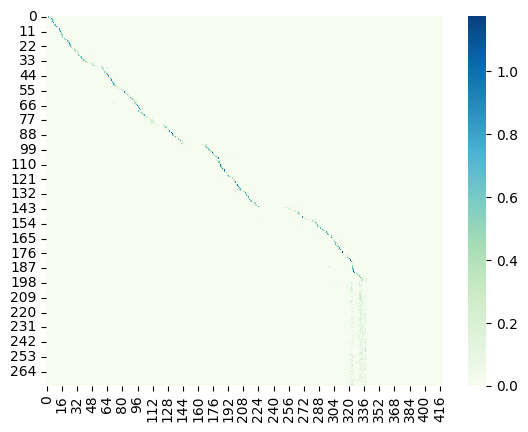

In [ ]:
e                   = 0
best_loss           = 20

checkpoint_root = os.path.join(os.getcwd(), "checkpoints-basic-transformer")
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(model, log="all")

checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-model.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epoch-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)

if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch % 2 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance = validate_fast(model, val_loader)
        print("Levenshtein Distance {:.04f}".format(levenshtein_distance))

        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr,
                "val_distance"      : levenshtein_distance})

    else:
        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr})

    # plotting the encoder-nearest and decoder-nearest attention weights
    attention_keys = list(attention_weights.keys())

    attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()

    # saving the cross-attention weights
    save_attention_plot(attention_weights_decoder_cross, epoch+100)

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage

    print("Saved epoch model")

    if best_loss >= train_loss:
        best_loss = train_loss
        save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        # wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()

In [ ]:
valid_actual_distance = validate_full(model, val_loader)

Val:   2%|▏         | 1/43 [00:32<22:48, 32.59s/it, running_distance=14.3125]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:49<16:04, 23.53s/it, running_distance=11.1641]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:15<16:28, 24.71s/it, running_distance=11.1458]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARREL EXPOSED HIM TO THE PENELTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:39<15:47, 24.29s/it, running_distance=13.0312]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDSTANDING


Val:  12%|█▏        | 5/43 [02:10<16:58, 26.81s/it, running_distance=12.7312]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ETTER INTO A STEWPEN WITH SUFFICIENT WANTER TO COVERT LET ITS DUGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Val:  14%|█▍        | 6/43 [02:39<16:56, 27.47s/it, running_distance=13.2109]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  I EXPLAINED THAT I'M TAKING MUSIC AND ALSO BIOLIGY ALTER ENGLISH IN FRENCH MUSIC THESE NORDS


Val:  16%|█▋        | 7/43 [03:08<16:47, 27.99s/it, running_distance=12.9464]


Ground Truth :  FROM UNDER THE LINING HE NOW PRODUCED A COLLECTION OF BRILLIANTLY COLORED PAPER FIGURES SEVERAL INCHES HIGH AND STIFF ENOUGH TO STAND ALONE
Prediction   :  FROM UNDER THE LINING HE NOW PRODUCED A COLLECTION OF BRILIANTLY COLORED PAPER FIGURES SEVERAL INJUST HIGH AND STIFFENG OF TO STAND ALONE


Val:  19%|█▊        | 8/43 [03:32<15:28, 26.52s/it, running_distance=12.3105]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAGG BY THE OTHER TWO


Val:  21%|██        | 9/43 [04:09<16:55, 29.86s/it, running_distance=12.8681]


Ground Truth :  HE SAYS THAT BY CUTTING THROUGH FOUR OR FIVE SLICES AT A TIME ALL THE BUTTER IS SQUEEZED OUT OF THE UPPER ONES WHILE THE BOTTOM ONE IS SWIMMING IN FAT LIQUID
Prediction   :  HE SAYS THAT BY CUTTING THROUGH FOUR FIVE SLICES AT A TIME ALL THE BUTTER IS SCLEASED OUT OF THE UPPER ONES WHILE THE BOT OF ONE IS SWIMING IN FAT LIQUID


Val:  23%|██▎       | 10/43 [04:40<16:37, 30.23s/it, running_distance=13.0656]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED THAT TO GARA TIPEST BECAUSE LIKE AN OLD LADY'S CUP OF TEAGUE IT IS WATER BEWHICHED


Val:  26%|██▌       | 11/43 [04:59<14:24, 27.02s/it, running_distance=14.0185]


Ground Truth :  BY THE TIME HE REACHED HIS OWN STREET HE WAS KEENLY ALIVE TO THE DIFFICULTIES OF HIS SITUATION AND WISHED OVER AND OVER THAT SOME SOLUTION WOULD OFFER ITSELF THAT HE COULD SEE HIS WAY OUT
Prediction   :  I THE CONLY REACHED HIS UNSCREET HE WILLIVED TO THE DIFFICULTY THE DIFFICULTY OF HIS ITUATION AND LISHED OVER THAT SUNCELITION WOULD OFFER ITSELF THAT HE COULD SEE HIS WAY OUT


Val:  28%|██▊       | 12/43 [05:30<14:27, 27.97s/it, running_distance=13.8464]


Ground Truth :  I WAS TO SEE THE SHEEP NOT NECESSARILY CLOSE AT HAND NOR TO GET THEM IN A SINGLE MOB BUT TO SEE ENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE WRONG THIS WAS NO DIFFICULT MATTER FOR THERE WERE NOT ABOVE EIGHT HUNDRED OF THEM AND BEING ALL BREEDING EWES THEY WERE PRETTY QUIET
Prediction   :  I WAS TO SEE THAT SHEEP NONESS AS AIRLY CLOSE AT HAND OR TO GET THE MINA SINGLE MOB BUT TO SEE ENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE WRONG THIS WAS NO DIFFICULT MATTER FOR THERE WERE NOT AM OF EIGHT HUNDRED OF THEM AND BEING ALL BREATING USE THEY WERE PRETTY QUIET


Val:  30%|███       | 13/43 [05:54<13:25, 26.83s/it, running_distance=13.6118]


Ground Truth :  THERE APPEARED TO BE NO KNOCKER THOUGH WHETHER IT HAD BEEN TWISTED OFF WAS MORE THAN I COULD SAY
Prediction   :  THEY APPEARED TO BE NO KNOCKER THOUGH WHETHER IT HAD BEEN TWISTED OFF WAS MORE THAN I COULD SAY


Val:  33%|███▎      | 14/43 [06:13<11:46, 24.37s/it, running_distance=12.9888]


Ground Truth :  THIS MAN WAS CLAD IN A BROWN CAMEL HAIR ROBE AND SANDALS AND A GREEN TURBAN WAS ON HIS HEAD
Prediction   :  THIS MAN WAS CLED IN A BROWN CAMBLED HERE ROBE AND SANDLES AND A GREEN TURBID WAS ON HIS HEAD


Val:  35%|███▍      | 15/43 [06:41<11:55, 25.54s/it, running_distance=12.7396]


Ground Truth :  HE SMILED GUILTILY AS HE ADDED BUT I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF
Prediction   :  HE SMILED GUILTILY AS HE ADDED BOD I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF


Val:  37%|███▋      | 16/43 [07:14<12:31, 27.83s/it, running_distance=12.7559]


Ground Truth :  NOT BE IT EVER REMEMBERED THAT THE SLIGHTEST SUSPICION OF IMMORALITY ATTACHES EITHER TO THE HEROINE OF THIS BOOK OR TO THE LEADING PHILOSOPHERS OF HER SCHOOL FOR SEVERAL CENTURIES
Prediction   :  NOT BE IT EVER REMEMBERED THAT THE SLIGHTS SUSPICION OF IMMORALITY ATTACHES ITHER TO THE HAIR ONE OF THIS BOOK OR TO THE LEADING FALOS OF HER SOVER SCHOOL FOR SCHOOL FOR SEVERAL CENTURIES


Val:  40%|███▉      | 17/43 [07:49<12:57, 29.90s/it, running_distance=13.9173]


Ground Truth :  BUT NEITHER THE GLORIFIED WOODS ON THE ONE HAND NOR THE LAKE ON THE OTHER COULD AT FIRST HOLD THE EYE
Prediction   :  BENEATHED THE GLORIFIED WOODS ON THE ONE HAND NO THE LAKE ON THE OTHER COULD AT FIRST COLD THE EYE


Val:  42%|████▏     | 18/43 [08:22<12:54, 30.96s/it, running_distance=13.8177]


Ground Truth :  THIS SWEETWATER AS THEY CALLED HIM WAS I HAVE SINCE UNDERSTOOD ONE OF HIS PROTEGES AND MORE OR LESS OF A FAVOURITE
Prediction   :  THIS SWEETWATER AS THEY CALLED HIM WAS I HAVE SINCE UNDERSTOOD ONE OF HE IS PROTER JASES AND MORE OR LESS A LIFT THEY RASH


Val:  44%|████▍     | 19/43 [08:53<12:23, 31.00s/it, running_distance=13.7541]


Ground Truth :  I PICKED IT UP AND COMING UP TO HIM JUST AS HE WAS GOING DOWN THE STEPS I HANDED IT TO HIM
Prediction   :  I PICKED IT UP AND COMING UP TO HIM JUST AS HE WAS GOING DOWN THE STEPS I HANDLED TO HIM


Val:  47%|████▋     | 20/43 [09:21<11:28, 29.95s/it, running_distance=13.6602]


Ground Truth :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGETIC NATURE OF HIS DISPOSITION HE HAD MADE THE ATTEMPT WITH SOME ZEAL
Prediction   :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGENTIVE NATURE OF HIS DISPOSITION HE HAD MADE THE ATTEMPT WITH SOMESEAL


Val:  49%|████▉     | 21/43 [09:50<10:56, 29.83s/it, running_distance=13.8423]


Ground Truth :  WHAT LED ME INTO IT WAS A CERTAIN THIRST FOR VENGEANCE WHICH IS STRONG ENOUGH TO DISTURB THE QUIETEST HEARTS
Prediction   :  WHAT LED ME INTO IT WAS A CERTAIN THIRST FOR VENGENCE WHICH IS STRONG ENOUGH TO DISTURBED THE QUIETEST HEARTS


Val:  51%|█████     | 22/43 [10:13<09:42, 27.73s/it, running_distance=13.5788]


Ground Truth :  OUR ROADS LIE TOGETHER DOCTOR
Prediction   :  OUR RAGES LIE TOGETHERED AFTER


Val:  53%|█████▎    | 23/43 [10:31<08:18, 24.91s/it, running_distance=13.3655]


Ground Truth :  HE'S A KIND NEIGHBORLY MAN AND HIS BOY WILL TAKE MY PLACE ABOUT THE HOUSE AND PROTECT YOU FAITHFULLY
Prediction   :  HE SUCKINGED NEIGHBORLY MAN AND TO SPOIL TAKE MY PLACE ABEL THE HOUSE AND PROTECTY FACELY


Val:  56%|█████▌    | 24/43 [11:08<08:57, 28.30s/it, running_distance=14.0879]


Ground Truth :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE THE CHANCE WHICH GIVES PERMISSION TO TAKE ACTION WHEN THEIR BEST YOUTH AND STRENGTH FOR ACTION HAVE BEEN USED UP IN SITTING STILL AND HOW MANY A ONE JUST AS HE SPRANG UP HAS FOUND WITH HORROR THAT HIS LIMBS ARE BENUMBED AND HIS SPIRITS ARE NOW TOO HEAVY
Prediction   :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE CHANCE WHICH GIVES PERMISSION TO TAKE ACTION WITH THEIR BEST YOUTH AND STRENGTH FORACTION HAVE BEEN USED UP IN THE SITTING STILL AND HOW MANY A ONE JUST AS HE SPRANG UP HIS FOUND WITH HORROR THAT HIS LIMBS ARE NOW TO HEAVY


Val:  58%|█████▊    | 25/43 [11:42<09:03, 30.18s/it, running_distance=14.2269]


Ground Truth :  YOU ARE NOT LIKE MY PEOPLE THE PINKIES AND THERE IS NO PLACE FOR YOU IN OUR COUNTRY
Prediction   :  YOU ARE NOT LIKE MY PEOPLE THE PINKIES AND THERE IS NO PLACE FOR YOU IN OUR HUNTRY


Val:  60%|██████    | 26/43 [12:08<08:10, 28.83s/it, running_distance=14.7194]


Ground Truth :  THIS WAS THE FIRST BIG BATTLE IN WHICH OUR REGIMENT HAD EVER BEEN ENGAGED
Prediction   :  THIS WAS THE FIRST BING BATTLEN WHICH ARE REGIMENT AND EVERBEN ENGAGED


Val:  63%|██████▎   | 27/43 [12:34<07:27, 27.98s/it, running_distance=14.5851]


Ground Truth :  A MAN IN THE WELL
Prediction   :  A MAN ON THE WELL


Val:  65%|██████▌   | 28/43 [12:51<06:09, 24.62s/it, running_distance=14.3638]


Ground Truth :  IT WAS ESTABLISHED AT SOUTHWARK
Prediction   :  IT WAS ESTABLISHED ITS SOUTH WORK


Val:  67%|██████▋   | 29/43 [13:11<05:28, 23.46s/it, running_distance=14.4892]


Ground Truth :  OUR TWO HORSES WITH THE LUGGAGE FOLLOWED OF THEIR OWN ACCORD WITHOUT REQUIRING WHIP OR SPUR
Prediction   :  OUR TWO HORSES WITH THE LONGET FALLEN OF THEIR OWN THE CORD WITHOUT REQUIRING WITH PERSPER


Val:  70%|██████▉   | 30/43 [13:37<05:13, 24.08s/it, running_distance=14.4068]


Ground Truth :  WE NEED KENTUCKY AND I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STATE TO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO AS WELL UP THERE
Prediction   :  WE NEED CONTUCKING I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STATY TO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO AS WELL UP THERE


Val:  72%|███████▏  | 31/43 [13:57<04:35, 22.92s/it, running_distance=14.1764]


Ground Truth :  NO I AM THE LIGHTER OF THE TWO URGED TAD
Prediction   :  NO I AM THE LIGHTER OF THE TWO EARGED HEAD


Val:  74%|███████▍  | 32/43 [14:13<03:50, 20.92s/it, running_distance=14.3135]


Ground Truth :  NONE OF YOU WILL BE FIT FOR DUTY TO MORROW
Prediction   :  THERE A VIEW WILL BE FET FOR DUTY MORROW


Val:  77%|███████▋  | 33/43 [14:36<03:32, 21.28s/it, running_distance=14.2164]


Ground Truth :  NOW FIFTEEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN AT ONE OF THEIR CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAT AN HONEST OLD WOMAN SPINNING FOR SHE HAD NEVER HEARD OF THE KING'S EDICT
Prediction   :  NOW FIFTEEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN OF THEIR CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAD AND HONEST OLD WOMAN SPINNING BUT SHE HAD NEVER HEARD OF THE KING'S EATIC


Val:  79%|███████▉  | 34/43 [15:06<03:36, 24.11s/it, running_distance=14.0041]


Ground Truth :  AND HE STRODE DOWN BETWEEN THE MARBLE TABLES AND OUT BY THE SWING DOOR IT WAS A VERY GOOD EXIT
Prediction   :  AND HE STROWED DOWN BETWEEN THE MARBLE TABLES AND OUT BY THE SWING DOOR IT WAS A VERY GOOD EXIT


Val:  81%|████████▏ | 35/43 [15:36<03:25, 25.71s/it, running_distance=14.2228]


Ground Truth :  IN THIS SAME DISTRICT IS THE MINT IN COMMERCIAL STREET BETWEEN MONTGOMERY AND KEARNY STREETS
Prediction   :  IN THE SAME DISTRUCT IS THE MINT IN COMMARCIAL STRAIGHT BETWEEN MUT GROMERY IN COURNEY STRAIGHTS


Val:  84%|████████▎ | 36/43 [15:50<02:36, 22.38s/it, running_distance=14.2717]


Ground Truth :  HIS OWN SKIN HAD SIZZLED UNDER THE RED HOT BRAND HE MURMURED SOFTLY
Prediction   :  HIS OWN SKINIANS CILLED UNTO THE RED HOT GRANTEEMERITE MERITS THOUGHLY


Val:  86%|████████▌ | 37/43 [16:14<02:16, 22.82s/it, running_distance=14.2272]


Ground Truth :  HIS SUCCESS SEEMS TO HAVE BEEN THE OUTGROWTH OF HARD STUDY AND ABILITY TO PERFORM THE MOST EXHAUSTIVE LABOR WITHOUT FATIGUE
Prediction   :  HIS SUCCESS SEEMS TO HAVE BEEN THE OUT GROTH OF HARD STUDY AND ABILITY TO ERFORM THE MOST EXHAUST OF LABOUR WITHOUT FATE


Val:  88%|████████▊ | 38/43 [16:46<02:07, 25.51s/it, running_distance=14.1949]


Ground Truth :  MY OWN REGIMENT WAS IN THE ADVANCE
Prediction   :  MY UNREGIMENT WAS IN THE ADVANCE


Val:  91%|█████████ | 39/43 [17:14<01:44, 26.24s/it, running_distance=14.7784]


Ground Truth :  WE ARE GOING INTO THE FOREST TO HEW WOOD AND IN THE EVENING WHEN WE ARE READY WE WILL COME AND FETCH YOU AGAIN
Prediction   :  WE ARE GLING INTO THE FARTH THE UBLED IN THEN EVENING WITH ARE READY WILCOME BET YOU AGAIN


Val:  93%|█████████▎| 40/43 [17:32<01:11, 23.87s/it, running_distance=14.5797]


Ground Truth :  SHE ASKED DIRECTLY IF HER FATHER WAS DEAD
Prediction   :  SHE ASKED DIRECTLY OF HER FATHER WAS DEAD


Val:  95%|█████████▌| 41/43 [17:54<00:46, 23.36s/it, running_distance=14.4680]


Ground Truth :  NOW HELICON MUST NEEDS POUR FORTH FOR ME AND WITH HER CHOIR URANIA MUST ASSIST ME TO PUT IN VERSE THINGS DIFFICULT TO THINK
Prediction   :  NOW HOW ACALM UST KNEES POOR FORTH FOR ME AND WITH HER QUIRE YOUROUNIA MUST ASSIST ME TO PUT INVERSE THINGS DIFFICULT TO THINK


Val:  98%|█████████▊| 42/43 [18:22<00:24, 24.55s/it, running_distance=14.4635]


Ground Truth :  AND IN HIS SPEECH HE LAUGH'D AND LAUGH'D AGAIN THEN WHILE IT WAS HIS PLEASURE TO REMAIN I CHANCED TO LOOK THE WAY HE HAD DRAWN NEAR AND SAW THE LADIES JOAN AND BEATRICE APPROACH ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARVEL INSTANTLY
Prediction   :  IT IN HIS SEEPS HE LAUGHED AGAIN THEN WHILE IT WAS HIS PLEASURED REMAIN I CHANCED TO LOOK THE WAY HE HAD DRONG NEAR AND SAW THE LADIES JONE AND BEATRESS APPROACH ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARBLE INSTANTLY



Ground Truth :  THOU LIKE ARCTURUS STEADFAST IN THE SKIES WITH TARDY SENSE GUIDEST THY KINGDOM FAIR BEARING ALONE THE LOAD OF LIBERTY
Prediction   :  THOU LIKE ARTERES STEADFAST IN THE SKIES WITH TARTY SENSE GUITEST BY KING THEM FAIR BEARING ALONE BELOWED OF LIBERTY


## Testing

In [ ]:
model.eval()

# progress bar
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)

all_predictions = []

for i, data in enumerate(test_loader):
    inputs, inputs_lengths = data
    inputs                 = inputs.to(device)

    with torch.inference_mode():
        greedy_predictions = model.recognize(inputs, inputs_lengths)

    greedy_predictions = greedy_predictions.detach().cpu().numpy()

    for batch_idx in range(greedy_predictions.shape[0]):
        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab= VOCAB)
        pred_string = ''.join(pred_sliced)
        all_predictions.append(pred_string)

    batch_bar.update()

Test: 100%|██████████| 41/41 [17:59<00:00, 25.49s/it]

In [ ]:
%cd /content/
df = pd.DataFrame({
    "index" : list(range(len(all_predictions))),
    "label" : all_predictions
})

df.to_csv("test.csv", index=False)

/content


In [ ]:
!kaggle competitions submit -c automatic-speech-recognition-s24 -f test.csv -m "HW4P2 Preliminary Submission"

100% 279k/279k [00:01<00:00, 158kB/s]
Successfully submitted to Automatic Speech Recognition (ASR)

In [ ]:
# TODO Sumbit predictions to Kaggle

# PART #2 Full Transformer (Encoder-Decoder)

Using an LSTM encoder helps to capture some dependencies in the input sequence which helps the transformer decoder to decode. However, we can do more than that. The transformer encoder plays a crucial role by processing the input sequence into a high-dimensional space, capturing complex relationships between elements. It uses self-attention to understand the context around each feature, enabling the model to grasp subtle nuances and dependencies, crucial for our speech recognition task and improving performance.

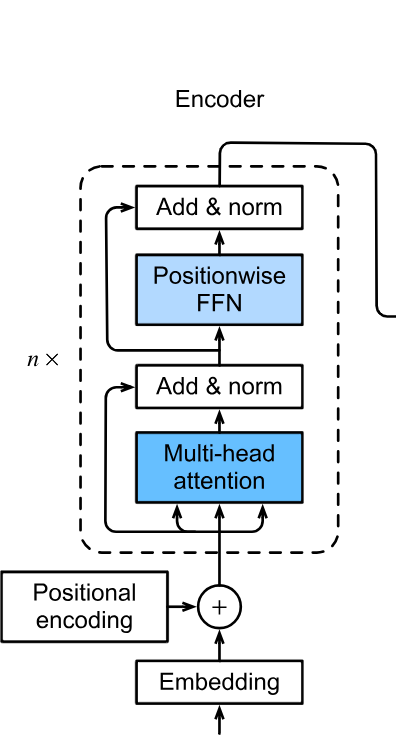

## Transformer Encoder

In [ ]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # @TODO: fill in the blanks appropriately (given the modules above)
        self.mha        = MultiHeadAttention(num_heads, d_model, dropout)
        self.ffn        = FeedForward(d_model, d_ff, dropout)

        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout1   = nn.Dropout(dropout)
        self.dropout2   = nn.Dropout(dropout)

    def forward(self, inp):

        # Multi-Head Attention
        #   (1) perform Multi-Head Attention on inp
        ''' TODO '''

        attn_output1, slf_attn_weights = self.mha(inp, inp, inp)

        # Skip (Residual) Connection
        #   (1) perform dropout
        #   (2) add the input as a skip connection
        ''' TODO '''

        attn_output1 = self.dropout1(attn_output1)


        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''

        attn_output1 = self.layernorm1(attn_output1 + inp)


        # Feed Forward Network
        #   (1) apply feed forward layer
        ''' TODO '''

        ffn_output = self.ffn(attn_output1)


        # Skip (Residual) Connection
        #   (1) perform dropout
        #   (2) add the output of the first layernorm as a skip connection
        ''' TODO '''
        ffn_output = self.dropout2(ffn_output)



        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        ffn_output = self.layernorm2(ffn_output + attn_output1)


        return ffn_output

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super(Encoder, self).__init__()

        # @TODO: fill in the blanks appropriately (given the modules above and P1 setup)
        self.embedding      = CNN_LSTM_Encoder(input_dim, 256, dropout)
        self.projection     = nn.Linear(1024, d_model)
        self.pos_encoding   = PositionalEncoding(d_model)

        # concatenating all num_layers EncoderLayer blocks
        self.enc_layers     = torch.nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.dropout        = nn.Dropout(dropout)
        self.layernorm      = nn.LayerNorm(d_model)

    def forward(self, x, input_lengths):

        # apply the CNN-LSTM Encoder (embedding)
        ''' TODO '''

        enc_output, enc_len = self.embedding(x, input_lengths)

        # adding projection layer to change dimension of encoder_outputs to match d_model
        ''' TODO '''
        projected = self.projection(enc_output)

        # apply Positional Encoding on these extracted features
        ''' TODO '''
        ped = self.pos_encoding(projected)

        # apply dropout as regularization technique
        ''' TODO '''

        output = self.dropout(ped)

        # passing inputs through Transformer Encoder blocks
        ''' TODO '''
        for el in self.enc_layers:
          output = el(output)

        output = self.layernorm(output)

        return output, enc_len

In [ ]:
class FullTransformer(torch.nn.Module):
    def __init__(self, input_dim, enc_num_layers, dec_num_layers, enc_num_heads, dec_num_heads,
                 d_model, d_ff, target_vocab_size, eos_token, sos_token,
                 pad_token, dropout=0.1, trans_max_seq_length=550, mfcc_max_seq_length=3260):

        super(FullTransformer, self).__init__()

        self.encoder = Encoder(input_dim, enc_num_layers, d_model, enc_num_heads, d_ff,  dropout)

        self.decoder = Decoder(dec_num_layers, d_model, dec_num_heads, d_ff,
                               dropout, target_vocab_size, trans_max_seq_length, eos_token, sos_token, pad_token)

    def forward(self, padded_input, input_lengths, padded_target, target_lengths):
        # passing through Encoder
        encoder_output, encoder_lens = self.encoder(padded_input, input_lengths)

        # passing Encoder output and Attention masks through Decoder
        output, attention_weights = self.decoder(padded_target, encoder_output, encoder_lens)

        return output, attention_weights

    def recognize(self, inp, inp_len):
        """ sequence-to-sequence greedy search -- decoding one utterance at a time """

        encoder_outputs, encoder_lens = self.encoder(inp, inp_len)
        out = self.decoder.recognize_greedy_search(encoder_outputs, encoder_lens)

        return out

## Full Model Setup

In [ ]:
config

{'train_dataset': 'train-clean-100',
 'cepstral_norm': True,
 'input_dim': 27,
 'batch_size': 64,
 'enc_dropout': 0.23,
 'enc_num_layers': 1,
 'enc_num_heads': 1,
 'dec_dropout': 0.23,
 'dec_num_layers': 2,
 'dec_num_heads': 2,
 'd_model': 512,
 'd_ff': 2048,
 'learning_rate': '1E-4',
 'optimizer': 'AdamW',
 'momentum': 0.0,
 'nesterov': True,
 'scheduler': 'CosineAnnealing',
 'factor': 0.9,
 'patience': 3,
 'epochs': 100,
 'Name': 'Zhenjian Wang'}

In [ ]:
full_model = FullTransformer(
input_dim                   = 27,
enc_num_layers              = config["enc_num_layers"],
dec_num_layers              = config["dec_num_layers"],
enc_num_heads               = 4,
dec_num_heads               = 4,

d_model                     = config["d_model"],
d_ff                        = config["d_ff"],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

dropout                     = 0.1,

# decrease to a small number if you are just trying to implement the network
# we've computed the max length of the transcripts for you
trans_max_seq_length        = 550,
mfcc_max_seq_length         = 3260).to(device)

In [ ]:
### Load your best P1 model checkpoint
model.load_state_dict(torch.load('/content/gdrive/MyDrive/checkpoint-best-loss-model (1).pth')['model_state_dict'])

<All keys matched successfully>

Freezing model weights except for transformer encoder layers. This is like an initialization strategy so that the encoder learns the range of values required by the decoder. After about 3 epochs when this initialzation is done, unfreeze weights of the entire model and let it train.




In [ ]:
### Copy weights from P1 model to full model
### Freeze the weights of full transformer input embedding, linear projection, and decoder

full_model.encoder.embedding.load_state_dict(model.encoder.state_dict())
for param in full_model.encoder.embedding.parameters():
    param.requires_grad = False # TODO make it non-trainable

full_model.encoder.projection.load_state_dict(model.proj.state_dict())
for param in full_model.encoder.projection.parameters():
    param.requires_grad = False # TODO make it non-trainable

full_model.decoder.load_state_dict(model.decoder.state_dict())
for param in full_model.decoder.parameters():
    param.requires_grad = False # TODO make it non-trainable

## Loss, Optimizer, and Scheduler Definitions

In [ ]:
loss_func   = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

In [ ]:
''' defining optimizer '''

if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(full_model.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(full_model.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(full_model.parameters(), lr=float(config["learning_rate"]),
                                betas=(0.9, 0.999),
                                eps=1e-9,
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = config["epochs"], eta_min=1E-8)

## Experiments

In [ ]:
RESUME_LOGGING = True

Resuming from epoch 3
Epochs left:  98
Optimizer: 
 AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-09
    foreach: None
    fused: None
    initial_lr: 0.0001
    lr: 9.9778120420331e-05
    maximize: False
    weight_decay: 0.01
)



Epoch 3/100



Epoch 3/100: 
Train Loss 0.1582	 Train Perplexity 1.1736	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:05<04:04,  5.81s/it, running_distance=15.1406]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THAT ENABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:09<03:12,  4.70s/it, running_distance=12.1719]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIT HAND GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [00:16<03:45,  5.64s/it, running_distance=11.4271]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [00:22<03:42,  5.70s/it, running_distance=13.7578]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WIDER LAST LONGER AND IS FEEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STUPEN WITH SUFFICIENT WANTER TO COVERED LETTED STUGENTLY TO QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 13.8906


Saved epoch model
Saved best training model

Epoch 4/100



Epoch 4/100: 
Train Loss 0.1499	 Train Perplexity 1.1646	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 5/100



Epoch 5/100: 
Train Loss 0.1421	 Train Perplexity 1.1558	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:18<13:02, 18.62s/it, running_distance=18.0312]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THAT ENABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:22<06:54, 10.12s/it, running_distance=12.7812]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [00:29<05:37,  8.45s/it, running_distance=11.6927]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARREL EXPOSED HIM TO THE PENDLETIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [00:35<04:54,  7.56s/it, running_distance=12.7109]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS TO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 12.4875


Saved epoch model
Saved best training model

Epoch 6/100



Epoch 6/100: 
Train Loss 0.1333	 Train Perplexity 1.1449	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 7/100



Epoch 7/100: 
Train Loss 0.1308	 Train Perplexity 1.1425	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:06<04:50,  6.92s/it, running_distance=15.4688]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLES SO ONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSTOMPORTED EXCEPTED TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:11<03:38,  5.32s/it, running_distance=11.5000]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [00:17<03:50,  5.76s/it, running_distance=10.7969]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [00:24<04:05,  6.31s/it, running_distance=13.8320]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WIDER LAST LANGER AND THIS FEEP MORE AT MORE FROM ANTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S TOO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 13.3688


Saved epoch model
Saved best training model

Epoch 8/100



Epoch 8/100: 
Train Loss 0.1266	 Train Perplexity 1.1374	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 9/100



Epoch 9/100: 
Train Loss 0.1233	 Train Perplexity 1.1339	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:18<12:59, 18.56s/it, running_distance=18.4375]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUMPORTED EXCEPT A TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:22<06:48,  9.97s/it, running_distance=13.1328]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [00:29<05:39,  8.48s/it, running_distance=11.5677]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [00:36<05:12,  8.02s/it, running_distance=13.2734]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WADER LAST BLONGER AND ESCEEP WAR AT MORE FROM INTENSITY TORNS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STUPIN WITH SUFFICIENT WANDER TO COVERNED LET ITS TO GENTLY TO QUITE DONE WHEN TAKE IT OUT TO COOR
Levenshtein Distance 13.2375


Saved epoch model
Saved best training model

Epoch 10/100



Epoch 10/100: 
Train Loss 0.1226	 Train Perplexity 1.1334	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 11/100



Epoch 11/100: 
Train Loss 0.1092	 Train Perplexity 1.1171	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:08<05:47,  8.27s/it, running_distance=16.0625]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THAT ENABLES SULLAN IN A TRANCE TO HOMESBODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THEY HEAD CONHELS


Val:   5%|▍         | 2/43 [00:12<03:59,  5.84s/it, running_distance=12.6250]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [00:19<04:10,  6.26s/it, running_distance=11.2500]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [00:36<07:02, 10.82s/it, running_distance=15.3477]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  ME RANGE WIDER LAST LONGER AND A SPEEP MORE AT MORE FROM A TENSITY TOWARNS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S DUGENLY TILL QUITE DONE WHEN TAKEN IT OUT TO COOL
Levenshtein Distance 14.4375


Saved epoch model
Saved best training model

Epoch 12/100


Train:   4%|▍         | 20/446 [00:07<02:41,  2.64it/s, loss=0.1108, perplexity=1.1180]

KeyboardInterrupt: 

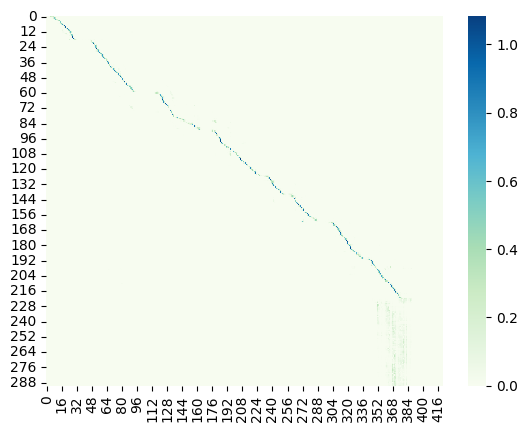

In [ ]:
###  Now let's train the encoder to master the encoder input ranges
e                   = 0
best_loss           = 10.0

checkpoint_root = os.path.join(os.getcwd(), 'checkpointsfull')
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(full_model, log="all")

checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-modelfull.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epochfull-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)

if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load("/content/checkpointsfull/checkpoint-best-loss-modelfull.pth")

    full_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(full_model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch % 2 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance = validate_fast(full_model, val_loader)
        print("Levenshtein Distance {:.04f}".format(levenshtein_distance))

        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr,
                "val_distance"      : levenshtein_distance})

    else:
        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr})

    # plotting the encoder-nearest and decoder-nearest attention weights
    attention_keys = list(attention_weights.keys())

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()
    save_attention_plot(attention_weights_decoder_cross, epoch)

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(full_model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage

    print("Saved epoch model")

    # the first time we add the transformer encoder block, we freeze all other weights
    #   except the transformer encoder weights and train this partially-frozen model
    #   for about 3 epochs to weight initialize the transformer encoder weights.
    #   This speeds up convergence of the entire network.
    # if epoch == 3:
    #     break

    if train_loss <= best_loss:
        best_loss = train_loss
        save_model(full_model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        # wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()

In [ ]:
    checkpoint = torch.load("/content/checkpointsfull/checkpoint-epochfull-4.pth")

    full_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

In [ ]:
validate_full(full_model, val_loader)

Val:   2%|▏         | 1/43 [00:05<03:58,  5.67s/it, running_distance=14.4219]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THAT ENABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:09<03:15,  4.78s/it, running_distance=11.5469]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WHERE DO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [00:16<03:42,  5.56s/it, running_distance=10.8958]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARREL EXPOSED HIM TO THE PENDLETIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [00:22<03:46,  5.82s/it, running_distance=12.3008]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WIDER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  12%|█▏        | 5/43 [00:29<03:51,  6.08s/it, running_distance=12.1375]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET ITS TO GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Val:  14%|█▍        | 6/43 [00:35<03:50,  6.24s/it, running_distance=14.5651]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  AND SPLAINED THAT ON TAKING MUSIC AND AS A WALLENTY OUTFOR ENGLISH IN FRENCE MUSIC THESE NORTS


Val:  16%|█▋        | 7/43 [00:42<03:46,  6.30s/it, running_distance=13.9464]


Ground Truth :  FROM UNDER THE LINING HE NOW PRODUCED A COLLECTION OF BRILLIANTLY COLORED PAPER FIGURES SEVERAL INCHES HIGH AND STIFF ENOUGH TO STAND ALONE
Prediction   :  FROM UNDER THE LINING HE NOW PRODUCED A COLLECTION OF BRILLIANTLY COLORED PAPER FIGURES SEVERAL INJUST HIGH AND STIFF ENOUGH TO STAND ALONE


Val:  19%|█▊        | 8/43 [00:45<03:13,  5.54s/it, running_distance=13.1172]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAGG BY THE OTHER TWO


Val:  21%|██        | 9/43 [00:53<03:31,  6.22s/it, running_distance=13.5590]


Ground Truth :  HE SAYS THAT BY CUTTING THROUGH FOUR OR FIVE SLICES AT A TIME ALL THE BUTTER IS SQUEEZED OUT OF THE UPPER ONES WHILE THE BOTTOM ONE IS SWIMMING IN FAT LIQUID
Prediction   :  HE SAYS THAT BY CUTTING THROUGH FOUR FIVE SLICES AT A TIME ALL THE BUTTER IS SCLEASED OUT OF THE UPPER ONES WHILE THE BOTTOM ONE IS SWIMMING IN FAT LEQUID


Val:  23%|██▎       | 10/43 [01:00<03:31,  6.41s/it, running_distance=13.6328]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED THAT TO GARER TYPEST BECAUSE LIKE AN OLD LADY'S CUP OF TEED IT IS WATER BE WHICH TO


Val:  26%|██▌       | 11/43 [01:05<03:07,  5.84s/it, running_distance=12.9233]


Ground Truth :  BY THE TIME HE REACHED HIS OWN STREET HE WAS KEENLY ALIVE TO THE DIFFICULTIES OF HIS SITUATION AND WISHED OVER AND OVER THAT SOME SOLUTION WOULD OFFER ITSELF THAT HE COULD SEE HIS WAY OUT
Prediction   :  BY THE TIME HE REACHED HIS OWN STREET HE WAS KEENLY ALIVED TO THE DIFFICULTIES OF HIS SITUATION AND WISHED OVER IN OVER THAT SOME SOLUTION WOULD OFFER IN THESELF THAT HE COULD SEE HIS WAY OUT


Val:  28%|██▊       | 12/43 [01:12<03:13,  6.23s/it, running_distance=12.8242]


Ground Truth :  I WAS TO SEE THE SHEEP NOT NECESSARILY CLOSE AT HAND NOR TO GET THEM IN A SINGLE MOB BUT TO SEE ENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE WRONG THIS WAS NO DIFFICULT MATTER FOR THERE WERE NOT ABOVE EIGHT HUNDRED OF THEM AND BEING ALL BREEDING EWES THEY WERE PRETTY QUIET
Prediction   :  I WAS TO SEE THE SHEEP NONESSASARELY CLOSE AT HAND OR TO GET THEM IN A SINGLE MOB BUT TO SEE ENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE WRONG THIS WAS NO DIFFICULT MATTER FOR THEY WERE NOT AMOVE EIGHT HUNDRED OF THEM AND BEING ALL BREADING USE THEY WERE PRETTY QUIET


Val:  30%|███       | 13/43 [01:17<03:01,  6.05s/it, running_distance=12.7200]


Ground Truth :  THERE APPEARED TO BE NO KNOCKER THOUGH WHETHER IT HAD BEEN TWISTED OFF WAS MORE THAN I COULD SAY
Prediction   :  THEY REPEARED TO BE NO KNOCKER THE WHETHER IT HAD BEEN TWISTED OFF WAS MORE THAN I COULD SAY


Val:  33%|███▎      | 14/43 [01:22<02:39,  5.49s/it, running_distance=12.2444]


Ground Truth :  THIS MAN WAS CLAD IN A BROWN CAMEL HAIR ROBE AND SANDALS AND A GREEN TURBAN WAS ON HIS HEAD
Prediction   :  THIS MAN WAS CLAD IN A BROWN CALIL HERE ROBE AND SANDLES AND A GREEN TURBID WAS ON HIS HEAD


Val:  35%|███▍      | 15/43 [01:27<02:33,  5.47s/it, running_distance=11.9688]


Ground Truth :  HE SMILED GUILTILY AS HE ADDED BUT I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF
Prediction   :  HE SMILED GUILTILY AS HE ADDED BUT I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF


Val:  37%|███▋      | 16/43 [01:33<02:34,  5.71s/it, running_distance=12.2578]


Ground Truth :  NOT BE IT EVER REMEMBERED THAT THE SLIGHTEST SUSPICION OF IMMORALITY ATTACHES EITHER TO THE HEROINE OF THIS BOOK OR TO THE LEADING PHILOSOPHERS OF HER SCHOOL FOR SEVERAL CENTURIES
Prediction   :  NOT BE IT EVER REMEMBERED THAT THE SLIGHTS SUSPICION OF IMMORALITY ATTACHESIDE THEIR TO THE HAIR ONE OF THIS BOOK OR TO THE LEADING FILLOSS OF HERSOVER SCHOOL FOR SCHOOL FOR SCHOOL FOR SENTURIES


Val:  40%|███▉      | 17/43 [01:52<04:13,  9.74s/it, running_distance=13.4770]


Ground Truth :  BUT NEITHER THE GLORIFIED WOODS ON THE ONE HAND NOR THE LAKE ON THE OTHER COULD AT FIRST HOLD THE EYE
Prediction   :  BET NEITHED THE GLORIFIED WOODS ON THE ONE HAND NOR THE LAKE ON THE OTHER COULD AT FIRST COLD THE EYE


Val:  42%|████▏     | 18/43 [02:00<03:46,  9.06s/it, running_distance=13.4557]


Ground Truth :  THIS SWEETWATER AS THEY CALLED HIM WAS I HAVE SINCE UNDERSTOOD ONE OF HIS PROTEGES AND MORE OR LESS OF A FAVOURITE
Prediction   :  THIS SWEETWATER AS THEY CALLED HIM WAS I HAVE SINCE UNDERSTOOD ONE OF HIS PROTTER JASE AND MORE OR LESS OF THE VRIDGE


Val:  44%|████▍     | 19/43 [02:09<03:38,  9.09s/it, running_distance=13.5814]


Ground Truth :  I PICKED IT UP AND COMING UP TO HIM JUST AS HE WAS GOING DOWN THE STEPS I HANDED IT TO HIM
Prediction   :  I PICKED IT UP AND COMING UP TO HIM TRUST AS HE WAS GOING DOWN THE STEPS I HAND THAT IT TO HIM


Val:  47%|████▋     | 20/43 [02:15<03:08,  8.22s/it, running_distance=13.3875]


Ground Truth :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGETIC NATURE OF HIS DISPOSITION HE HAD MADE THE ATTEMPT WITH SOME ZEAL
Prediction   :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGETIC NATURE OF HIS DISPOSITION HE HAD MADE THE ATTEMPT WITH SOMESEAL


Val:  49%|████▉     | 21/43 [02:23<02:58,  8.10s/it, running_distance=13.4598]


Ground Truth :  WHAT LED ME INTO IT WAS A CERTAIN THIRST FOR VENGEANCE WHICH IS STRONG ENOUGH TO DISTURB THE QUIETEST HEARTS
Prediction   :  WOULD LED ME INTO IT WAS A CERTAIN THIRST FOR VENGEANCE WHICH IS STRONG ENOUGH TO DISTURBED THE QUIETEST HEARTS


Val:  51%|█████     | 22/43 [02:30<02:40,  7.64s/it, running_distance=13.1733]


Ground Truth :  OUR ROADS LIE TOGETHER DOCTOR
Prediction   :  OUR ROADS LIE TOGETHERED OFTER


Val:  53%|█████▎    | 23/43 [02:34<02:12,  6.62s/it, running_distance=12.9905]


Ground Truth :  HE'S A KIND NEIGHBORLY MAN AND HIS BOY WILL TAKE MY PLACE ABOUT THE HOUSE AND PROTECT YOU FAITHFULLY
Prediction   :  HE SUCKINED NEIGHBORALLY MAN AND TO SPOY WILL TAKE MY PLACE ABEL THE HOUSE AND RETECTY FACILY


Val:  56%|█████▌    | 24/43 [02:53<03:17, 10.41s/it, running_distance=13.9753]


Ground Truth :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE THE CHANCE WHICH GIVES PERMISSION TO TAKE ACTION WHEN THEIR BEST YOUTH AND STRENGTH FOR ACTION HAVE BEEN USED UP IN SITTING STILL AND HOW MANY A ONE JUST AS HE SPRANG UP HAS FOUND WITH HORROR THAT HIS LIMBS ARE BENUMBED AND HIS SPIRITS ARE NOW TOO HEAVY
Prediction   :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE THE CHANCE WHICH HIS PERMISSION TO TAKE ACTION WITH THEIR BEST YOUTH AND STRENGTH FOR ACTION HAVE BEEN USEDOPPED IN THE SITTING STILL AND HOW MANY A ONE JUST AS HE SPRANG UP HIS FOUND WITH HORROR THAT HIS LIMBS ARE NOW TO HEAVY


Val:  58%|█████▊    | 25/43 [03:01<02:52,  9.57s/it, running_distance=14.2475]


Ground Truth :  YOU ARE NOT LIKE MY PEOPLE THE PINKIES AND THERE IS NO PLACE FOR YOU IN OUR COUNTRY
Prediction   :  YOU ARE NOT LIKE MY PEOPLE THE PINKEYS AND THERE IS NO PLACE FOR YOU IN OUR HUNTRY


Val:  60%|██████    | 26/43 [03:07<02:28,  8.74s/it, running_distance=14.3570]


Ground Truth :  THIS WAS THE FIRST BIG BATTLE IN WHICH OUR REGIMENT HAD EVER BEEN ENGAGED
Prediction   :  THIS WAS THE FIRST BIG BATTLING WHICH OUR REGIMENT HAD EVERBEN ENGAGED


Val:  63%|██████▎   | 27/43 [03:12<02:01,  7.58s/it, running_distance=14.2778]


Ground Truth :  A MAN IN THE WELL
Prediction   :  THE MAN ON THE WELL


Val:  65%|██████▌   | 28/43 [03:16<01:37,  6.49s/it, running_distance=14.0480]


Ground Truth :  IT WAS ESTABLISHED AT SOUTHWARK
Prediction   :  IT WAS ESTABLISHED TO SOUTH WORK


Val:  67%|██████▋   | 29/43 [03:21<01:23,  5.96s/it, running_distance=13.9246]


Ground Truth :  OUR TWO HORSES WITH THE LUGGAGE FOLLOWED OF THEIR OWN ACCORD WITHOUT REQUIRING WHIP OR SPUR
Prediction   :  OUR TWO HORSES WITH THE LUNG ENTERFUL OF THEIR OWN ACCORD WITHOUT REQUIRING WITH ORSPER


Val:  70%|██████▉   | 30/43 [03:27<01:19,  6.08s/it, running_distance=13.8078]


Ground Truth :  WE NEED KENTUCKY AND I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STATE TO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO AS WELL UP THERE
Prediction   :  WE NEED CONTUCKING I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STATY TWO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO AS WELL UP THERE


Val:  72%|███████▏  | 31/43 [03:31<01:04,  5.42s/it, running_distance=13.6033]


Ground Truth :  NO I AM THE LIGHTER OF THE TWO URGED TAD
Prediction   :  NO I AM THE LIGHTER OF THE TWO EARGED HEAD


Val:  74%|███████▍  | 32/43 [03:36<00:56,  5.11s/it, running_distance=13.8159]


Ground Truth :  NONE OF YOU WILL BE FIT FOR DUTY TO MORROW
Prediction   :  NOT VIEW WILL BE FET FOR DUTY TO MORROW


Val:  77%|███████▋  | 33/43 [03:41<00:51,  5.12s/it, running_distance=13.7557]


Ground Truth :  NOW FIFTEEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN AT ONE OF THEIR CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAT AN HONEST OLD WOMAN SPINNING FOR SHE HAD NEVER HEARD OF THE KING'S EDICT
Prediction   :  NOW FIFTEEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN ONE OF HER CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAD AND HONEST OLD WOMAN SPINNING BUT SHE HAD NEVER HEARD OF THE CANG'S EATIC


Val:  79%|███████▉  | 34/43 [03:46<00:47,  5.29s/it, running_distance=13.5524]


Ground Truth :  AND HE STRODE DOWN BETWEEN THE MARBLE TABLES AND OUT BY THE SWING DOOR IT WAS A VERY GOOD EXIT
Prediction   :  AND HE STROWED DOWN BETWEEN THE MARBLE TABLES AND OUT BY THE SWING DOOR IT WAS A VERY GOOD EXIT


Val:  81%|████████▏ | 35/43 [03:53<00:45,  5.64s/it, running_distance=13.5638]


Ground Truth :  IN THIS SAME DISTRICT IS THE MINT IN COMMERCIAL STREET BETWEEN MONTGOMERY AND KEARNY STREETS
Prediction   :  IN THE SAME DISTRECT IS THE MINT IN COMMERCIAL STREET BUT WEEN MUT GOMERY IN CARNEY STREETS


Val:  84%|████████▎ | 36/43 [03:56<00:35,  5.02s/it, running_distance=13.5820]


Ground Truth :  HIS OWN SKIN HAD SIZZLED UNDER THE RED HOT BRAND HE MURMURED SOFTLY
Prediction   :  HIS OWN SKIN HAD SILLED UNDER THE RED HOT GRANTEEMER WERE SOUGHTLY


Val:  86%|████████▌ | 37/43 [04:12<00:49,  8.25s/it, running_distance=13.6410]


Ground Truth :  HIS SUCCESS SEEMS TO HAVE BEEN THE OUTGROWTH OF HARD STUDY AND ABILITY TO PERFORM THE MOST EXHAUSTIVE LABOR WITHOUT FATIGUE
Prediction   :  HIS SUCCESS SEEMS TO HAVE BEEN THE OUT GROWTH OF HARD STUDY AND ABILITY TO ERFORM THE MOST EXHAUSTIVE LABOR WITHOUT FATIGUE


Val:  88%|████████▊ | 38/43 [04:21<00:41,  8.25s/it, running_distance=13.5938]


Ground Truth :  MY OWN REGIMENT WAS IN THE ADVANCE
Prediction   :  MY UNE REGIMENT WAS IN THE ADVANCE


Val:  91%|█████████ | 39/43 [04:24<00:27,  6.89s/it, running_distance=13.4335]


Ground Truth :  WE ARE GOING INTO THE FOREST TO HEW WOOD AND IN THE EVENING WHEN WE ARE READY WE WILL COME AND FETCH YOU AGAIN
Prediction   :  WE ARE GOING INTO THE FOREST TO HEW WOOD AND IN THE EVENING ONE WERE AREADY WE WILL COME INFECT YOU AGAIN


Val:  93%|█████████▎| 40/43 [04:29<00:18,  6.26s/it, running_distance=13.2965]


Ground Truth :  SHE ASKED DIRECTLY IF HER FATHER WAS DEAD
Prediction   :  SHE ASKED DIRECTLY OF HER FATHER WAS DEAD


Val:  95%|█████████▌| 41/43 [04:34<00:11,  5.99s/it, running_distance=13.1639]


Ground Truth :  NOW HELICON MUST NEEDS POUR FORTH FOR ME AND WITH HER CHOIR URANIA MUST ASSIST ME TO PUT IN VERSE THINGS DIFFICULT TO THINK
Prediction   :  NOW HELECAL MUST NEEDS POOR FORTH FOR ME AND WITH HER QUIRE YOURONIA MUST ASSIST ME TO PUT INVERSE THINGS DIFFICULT TO THINK


Val:  98%|█████████▊| 42/43 [04:51<00:09,  9.29s/it, running_distance=13.1905]


Ground Truth :  AND IN HIS SPEECH HE LAUGH'D AND LAUGH'D AGAIN THEN WHILE IT WAS HIS PLEASURE TO REMAIN I CHANCED TO LOOK THE WAY HE HAD DRAWN NEAR AND SAW THE LADIES JOAN AND BEATRICE APPROACH ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARVEL INSTANTLY
Prediction   :  IT IN HIS SEEPS HE LAUGHED AND LAUGHED AGAIN THEN WHILE IT WAS HIS PLEASURED REMAIN I CHANCED TO LOOK THE WAY HE HAD DRONG NEAR AND SAW THE LADIES JONE AND BEATROUS APPROACHED ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARBLE INSTANTLY



Ground Truth :  THOU LIKE ARCTURUS STEADFAST IN THE SKIES WITH TARDY SENSE GUIDEST THY KINGDOM FAIR BEARING ALONE THE LOAD OF LIBERTY
Prediction   :  THOU LIKE ARTUROUS STEADFAST IN A SKIES WITH TARTY SENSE GUIDEST BY KINGDOM FAIR BEARING ALONE BELOAT OF LIBERTY


13.629457364341086

In [ ]:
### TODO Unfreeze the weights of full transformer input embedding and decoder
# @NOTE: after unfreezing, continue training the P2 model for more epochs to achieve best results!

for param in full_model.encoder.embedding.parameters():
    param.requires_grad = True # TODO make it trainable

for param in full_model.encoder.projection.parameters():
    param.requires_grad = True # TODO make it trainable

for param in full_model.decoder.parameters():
    param.requires_grad = True # TODO make it trainable

## Testing

In [ ]:
checkpoint_path = "/content/checkpointsfull/checkpoint-epochfull-27.pth"


checkpoint = torch.load(checkpoint_path)

full_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
e = checkpoint['epoch']

print("Resuming from epoch {}".format(e+1))
print("Epochs left: ", config['epochs']-e)
print("Optimizer: \n", optimizer)


Resuming from epoch 28
Epochs left:  73
Optimizer: 
 AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-09
    foreach: None
    fused: None
    initial_lr: 0.0001
    lr: 7.679366061497496e-05
    maximize: False
    weight_decay: 0.01
)


In [ ]:
full_model.eval()

# progress bar
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)

all_predictions = []

for i, data in enumerate(test_loader):
    inputs, inputs_lengths = data
    inputs                 = inputs.to(device)

    with torch.inference_mode():
        greedy_predictions = full_model.recognize(inputs, inputs_lengths)

    greedy_predictions = greedy_predictions.detach().cpu().numpy()

    for batch_idx in range(greedy_predictions.shape[0]):
        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab= VOCAB)
        pred_string = ''.join(pred_sliced)
        all_predictions.append(pred_string)

    batch_bar.update()

Test: 100%|██████████| 41/41 [04:54<00:00, 11.63s/it]

In [ ]:
%cd /content/
df = pd.DataFrame({
    "index" : list(range(len(all_predictions))),
    "label" : all_predictions
})

df.to_csv("improved.csv", index=False)

/content


In [ ]:
!kaggle competitions submit -c automatic-speech-recognition-s24 -f improved.csv -m "It's been a ride :)"

100% 285k/285k [00:01<00:00, 197kB/s]
Successfully submitted to Automatic Speech Recognition (ASR)